In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b50','k7_b50','k9_b50','k11_b50','k13_b50','k15_b50','k17_b50','k19_b50','k21_b50']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b50_k7_b50_k9_b50_k11_b50_k13_b50_k15_b50_k17_b50_k19_b50_k21_b50_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000



 1/64 [..............................] - ETA: 1:37 - loss: 0.3014 - STD: 2.0492e-04 - MAE: 0.5399


 3/64 [>.............................] - ETA: 1s - loss: 0.1465 - STD: 4.4059e-04 - MAE: 0.3339  


 5/64 [=>............................] - ETA: 2s - loss: 0.0927 - STD: 3.6664e-04 - MAE: 0.2329


 6/64 [=>............................] - ETA: 3s - loss: 0.0803 - STD: 3.2179e-04 - MAE: 0.2112


 7/64 [==>...........................] - ETA: 3s - loss: 0.0722 - STD: 2.8392e-04 - MAE: 0.1979


 8/64 [==>...........................] - ETA: 3s - loss: 0.0665 - STD: 2.5263e-04 - MAE: 0.1894


 9/64 [===>..........................] - ETA: 3s - loss: 0.0621 - STD: 2.2674e-04 - MAE: 0.1832


10/64 [===>..........................] - ETA: 3s - loss: 0.0588 - STD: 2.0529e-04 - MAE: 0.1788


11/64 [====>.........................] - ETA: 3s - loss: 0.0562 - STD: 1.8723e-04 - MAE: 0.1754


12/64 [====>.........................] - ETA: 3s - loss: 0.0541 - STD: 1.7193e-04 - MAE: 0.1729


13/64 [=====>........................] - ETA: 3s - loss: 0.0523 - STD: 1.5894e-04 - MAE: 0.1708


14/64 [=====>........................] - ETA: 3s - loss: 0.0507 - STD: 1.4786e-04 - MAE: 0.1688


15/64 [======>.......................] - ETA: 5s - loss: 0.0505 - STD: 1.3838e-04 - MAE: 0.1671


17/64 [======>.......................] - ETA: 4s - loss: 0.0479 - STD: 1.2296e-04 - MAE: 0.1640


19/64 [=======>......................] - ETA: 4s - loss: 0.0457 - STD: 1.1103e-04 - MAE: 0.1610


20/64 [========>.....................] - ETA: 3s - loss: 0.0447 - STD: 1.0605e-04 - MAE: 0.1595


21/64 [========>.....................] - ETA: 3s - loss: 0.0437 - STD: 1.0161e-04 - MAE: 0.1578


22/64 [=========>....................] - ETA: 3s - loss: 0.0428 - STD: 9.7587e-05 - MAE: 0.1562


23/64 [=========>....................] - ETA: 3s - loss: 0.0419 - STD: 9.3979e-05 - MAE: 0.1543


24/64 [==========>...................] - ETA: 3s - loss: 0.0409 - STD: 9.0743e-05 - MAE: 0.1525


25/64 [==========>...................] - ETA: 3s - loss: 0.0400 - STD: 8.7777e-05 - MAE: 0.1505


26/64 [===========>..................] - ETA: 3s - loss: 0.0391 - STD: 8.5113e-05 - MAE: 0.1484


27/64 [===========>..................] - ETA: 3s - loss: 0.0382 - STD: 8.2563e-05 - MAE: 0.1463


28/64 [============>.................] - ETA: 3s - loss: 0.0373 - STD: 8.0327e-05 - MAE: 0.1441


29/64 [============>.................] - ETA: 3s - loss: 0.0364 - STD: 7.8221e-05 - MAE: 0.1419


30/64 [=============>................] - ETA: 2s - loss: 0.0356 - STD: 7.6287e-05 - MAE: 0.1397


31/64 [=============>................] - ETA: 2s - loss: 0.0347 - STD: 7.4462e-05 - MAE: 0.1377


32/64 [==============>...............] - ETA: 2s - loss: 0.0339 - STD: 7.2816e-05 - MAE: 0.1357


33/64 [==============>...............] - ETA: 2s - loss: 0.0332 - STD: 7.1223e-05 - MAE: 0.1340


34/64 [==============>...............] - ETA: 2s - loss: 0.0325 - STD: 6.9625e-05 - MAE: 0.1326


35/64 [===============>..............] - ETA: 2s - loss: 0.0319 - STD: 6.8160e-05 - MAE: 0.1313


36/64 [===============>..............] - ETA: 2s - loss: 0.0313 - STD: 6.6828e-05 - MAE: 0.1301


37/64 [================>.............] - ETA: 2s - loss: 0.0308 - STD: 6.5551e-05 - MAE: 0.1291


38/64 [================>.............] - ETA: 2s - loss: 0.0303 - STD: 6.4316e-05 - MAE: 0.1282


39/64 [=================>............] - ETA: 2s - loss: 0.0298 - STD: 6.3100e-05 - MAE: 0.1273


40/64 [=================>............] - ETA: 2s - loss: 0.0293 - STD: 6.1907e-05 - MAE: 0.1265


41/64 [==================>...........] - ETA: 1s - loss: 0.0289 - STD: 6.0754e-05 - MAE: 0.1256


42/64 [==================>...........] - ETA: 1s - loss: 0.0285 - STD: 5.9617e-05 - MAE: 0.1247


43/64 [===================>..........] - ETA: 1s - loss: 0.0280 - STD: 5.8564e-05 - MAE: 0.1237


44/64 [===================>..........] - ETA: 1s - loss: 0.0276 - STD: 5.7547e-05 - MAE: 0.1228


45/64 [====================>.........] - ETA: 1s - loss: 0.0272 - STD: 5.6578e-05 - MAE: 0.1218


46/64 [====================>.........] - ETA: 1s - loss: 0.0268 - STD: 5.5610e-05 - MAE: 0.1209


47/64 [=====================>........] - ETA: 1s - loss: 0.0265 - STD: 5.4602e-05 - MAE: 0.1199


48/64 [=====================>........] - ETA: 1s - loss: 0.0261 - STD: 5.3654e-05 - MAE: 0.1190


49/64 [=====================>........] - ETA: 1s - loss: 0.0258 - STD: 5.2769e-05 - MAE: 0.1181


50/64 [======================>.......] - ETA: 1s - loss: 0.0255 - STD: 5.1916e-05 - MAE: 0.1173


51/64 [======================>.......] - ETA: 1s - loss: 0.0252 - STD: 5.1072e-05 - MAE: 0.1165


52/64 [=======================>......] - ETA: 1s - loss: 0.0249 - STD: 5.0224e-05 - MAE: 0.1157


53/64 [=======================>......] - ETA: 0s - loss: 0.0246 - STD: 4.9458e-05 - MAE: 0.1150


54/64 [========================>.....] - ETA: 0s - loss: 0.0243 - STD: 4.8706e-05 - MAE: 0.1142


55/64 [========================>.....] - ETA: 0s - loss: 0.0241 - STD: 4.7940e-05 - MAE: 0.1136


56/64 [=========================>....] - ETA: 0s - loss: 0.0238 - STD: 4.7207e-05 - MAE: 0.1129


57/64 [=========================>....] - ETA: 0s - loss: 0.0236 - STD: 4.6498e-05 - MAE: 0.1122


58/64 [==========================>...] - ETA: 0s - loss: 0.0233 - STD: 4.5844e-05 - MAE: 0.1116


59/64 [==========================>...] - ETA: 0s - loss: 0.0231 - STD: 4.5175e-05 - MAE: 0.1110


60/64 [===========================>..] - ETA: 0s - loss: 0.0229 - STD: 4.4524e-05 - MAE: 0.1105


61/64 [===========================>..] - ETA: 0s - loss: 0.0227 - STD: 4.3962e-05 - MAE: 0.1099


62/64 [============================>.] - ETA: 0s - loss: 0.0225 - STD: 4.3392e-05 - MAE: 0.1094


63/64 [============================>.] - ETA: 0s - loss: 0.0223 - STD: 4.2826e-05 - MAE: 0.1089


64/64 [==============================] - ETA: 0s - loss: 0.0221 - STD: 4.2330e-05 - MAE: 0.1084


64/64 [==============================] - 8s 97ms/step - loss: 0.0221 - STD: 4.2330e-05 - MAE: 0.1084 - val_loss: 0.0095 - val_STD: 9.1076e-06 - val_MAE: 0.0782


Epoch 2/10000



 1/64 [..............................] - ETA: 7s - loss: 0.0098 - STD: 1.1192e-05 - MAE: 0.0790


 2/64 [..............................] - ETA: 5s - loss: 0.0098 - STD: 1.0155e-05 - MAE: 0.0793


 3/64 [>.............................] - ETA: 5s - loss: 0.0099 - STD: 9.4183e-06 - MAE: 0.0796


 4/64 [>.............................] - ETA: 4s - loss: 0.0099 - STD: 9.2884e-06 - MAE: 0.0797


 5/64 [=>............................] - ETA: 4s - loss: 0.0099 - STD: 8.9884e-06 - MAE: 0.0796


 6/64 [=>............................] - ETA: 4s - loss: 0.0099 - STD: 9.1235e-06 - MAE: 0.0796


 7/64 [==>...........................] - ETA: 4s - loss: 0.0100 - STD: 8.7808e-06 - MAE: 0.0797


 8/64 [==>...........................] - ETA: 4s - loss: 0.0100 - STD: 8.9567e-06 - MAE: 0.0798


 9/64 [===>..........................] - ETA: 4s - loss: 0.0100 - STD: 9.1211e-06 - MAE: 0.0795


10/64 [===>..........................] - ETA: 4s - loss: 0.0100 - STD: 9.0452e-06 - MAE: 0.0794


11/64 [====>.........................] - ETA: 4s - loss: 0.0099 - STD: 9.0981e-06 - MAE: 0.0793


12/64 [====>.........................] - ETA: 4s - loss: 0.0099 - STD: 9.0006e-06 - MAE: 0.0791


13/64 [=====>........................] - ETA: 4s - loss: 0.0100 - STD: 8.9198e-06 - MAE: 0.0790


14/64 [=====>........................] - ETA: 4s - loss: 0.0099 - STD: 8.9215e-06 - MAE: 0.0789


15/64 [======>.......................] - ETA: 4s - loss: 0.0099 - STD: 8.9987e-06 - MAE: 0.0788


16/64 [======>.......................] - ETA: 3s - loss: 0.0100 - STD: 8.8994e-06 - MAE: 0.0787


17/64 [======>.......................] - ETA: 3s - loss: 0.0100 - STD: 8.8781e-06 - MAE: 0.0786


18/64 [=======>......................] - ETA: 3s - loss: 0.0100 - STD: 8.8530e-06 - MAE: 0.0785


19/64 [=======>......................] - ETA: 3s - loss: 0.0100 - STD: 8.8679e-06 - MAE: 0.0785


20/64 [========>.....................] - ETA: 3s - loss: 0.0100 - STD: 8.9394e-06 - MAE: 0.0784


21/64 [========>.....................] - ETA: 3s - loss: 0.0100 - STD: 8.8734e-06 - MAE: 0.0784


22/64 [=========>....................] - ETA: 3s - loss: 0.0100 - STD: 8.9050e-06 - MAE: 0.0783


23/64 [=========>....................] - ETA: 3s - loss: 0.0100 - STD: 8.9480e-06 - MAE: 0.0783


24/64 [==========>...................] - ETA: 3s - loss: 0.0100 - STD: 8.9296e-06 - MAE: 0.0783


25/64 [==========>...................] - ETA: 3s - loss: 0.0100 - STD: 8.9876e-06 - MAE: 0.0783


26/64 [===========>..................] - ETA: 3s - loss: 0.0099 - STD: 8.9267e-06 - MAE: 0.0783


27/64 [===========>..................] - ETA: 3s - loss: 0.0100 - STD: 8.8625e-06 - MAE: 0.0783


28/64 [============>.................] - ETA: 2s - loss: 0.0100 - STD: 8.8896e-06 - MAE: 0.0783


29/64 [============>.................] - ETA: 2s - loss: 0.0100 - STD: 8.9367e-06 - MAE: 0.0783


30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 8.9873e-06 - MAE: 0.0783


31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 9.0235e-06 - MAE: 0.0783


32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 8.9837e-06 - MAE: 0.0783


33/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 8.9586e-06 - MAE: 0.0783


34/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 8.9046e-06 - MAE: 0.0783


35/64 [===============>..............] - ETA: 2s - loss: 0.0099 - STD: 8.9349e-06 - MAE: 0.0783


36/64 [===============>..............] - ETA: 2s - loss: 0.0099 - STD: 8.9353e-06 - MAE: 0.0783


37/64 [================>.............] - ETA: 2s - loss: 0.0099 - STD: 8.9692e-06 - MAE: 0.0783


38/64 [================>.............] - ETA: 2s - loss: 0.0099 - STD: 8.9773e-06 - MAE: 0.0782


39/64 [=================>............] - ETA: 2s - loss: 0.0099 - STD: 8.9864e-06 - MAE: 0.0782


40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 9.0204e-06 - MAE: 0.0782


41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 8.9863e-06 - MAE: 0.0782


42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 8.9410e-06 - MAE: 0.0782


43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 8.8999e-06 - MAE: 0.0782


44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 8.8745e-06 - MAE: 0.0782


45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 8.9189e-06 - MAE: 0.0782


46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 8.9430e-06 - MAE: 0.0782


47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 8.9520e-06 - MAE: 0.0782


48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 8.9666e-06 - MAE: 0.0782


49/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 8.9883e-06 - MAE: 0.0781


50/64 [======================>.......] - ETA: 1s - loss: 0.0099 - STD: 8.9957e-06 - MAE: 0.0781


51/64 [======================>.......] - ETA: 1s - loss: 0.0099 - STD: 8.9865e-06 - MAE: 0.0782


52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 8.9886e-06 - MAE: 0.0781


53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 8.9931e-06 - MAE: 0.0782


54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 9.0010e-06 - MAE: 0.0782


55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 9.0156e-06 - MAE: 0.0782


56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 9.0333e-06 - MAE: 0.0782


57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 9.0402e-06 - MAE: 0.0782


58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 9.0326e-06 - MAE: 0.0782


59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 9.0509e-06 - MAE: 0.0782


60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 9.0616e-06 - MAE: 0.0782


61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 9.0713e-06 - MAE: 0.0781


62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 9.0787e-06 - MAE: 0.0781


63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 9.1227e-06 - MAE: 0.0781


64/64 [==============================] - 5s 84ms/step - loss: 0.0099 - STD: 9.1628e-06 - MAE: 0.0781 - val_loss: 0.0094 - val_STD: 7.4702e-06 - val_MAE: 0.0762


Epoch 3/10000



 1/64 [..............................] - ETA: 7s - loss: 0.0098 - STD: 9.1737e-06 - MAE: 0.0772


 2/64 [..............................] - ETA: 5s - loss: 0.0098 - STD: 9.1802e-06 - MAE: 0.0774


 3/64 [>.............................] - ETA: 5s - loss: 0.0097 - STD: 9.2546e-06 - MAE: 0.0769


 4/64 [>.............................] - ETA: 5s - loss: 0.0097 - STD: 9.4358e-06 - MAE: 0.0771


 5/64 [=>............................] - ETA: 4s - loss: 0.0097 - STD: 9.5270e-06 - MAE: 0.0770


 6/64 [=>............................] - ETA: 4s - loss: 0.0098 - STD: 9.5185e-06 - MAE: 0.0772


 7/64 [==>...........................] - ETA: 4s - loss: 0.0098 - STD: 9.5089e-06 - MAE: 0.0773


 8/64 [==>...........................] - ETA: 4s - loss: 0.0098 - STD: 9.5416e-06 - MAE: 0.0775


 9/64 [===>..........................] - ETA: 4s - loss: 0.0099 - STD: 9.7384e-06 - MAE: 0.0775


10/64 [===>..........................] - ETA: 4s - loss: 0.0099 - STD: 9.8501e-06 - MAE: 0.0775


11/64 [====>.........................] - ETA: 4s - loss: 0.0099 - STD: 9.7753e-06 - MAE: 0.0776


12/64 [====>.........................] - ETA: 4s - loss: 0.0099 - STD: 9.7792e-06 - MAE: 0.0776


13/64 [=====>........................] - ETA: 4s - loss: 0.0099 - STD: 9.8068e-06 - MAE: 0.0777


14/64 [=====>........................] - ETA: 4s - loss: 0.0099 - STD: 9.8662e-06 - MAE: 0.0777


15/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 9.9407e-06 - MAE: 0.0777


16/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 1.0005e-05 - MAE: 0.0777


17/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 1.0068e-05 - MAE: 0.0777


18/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 1.0132e-05 - MAE: 0.0777


19/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 1.0198e-05 - MAE: 0.0777


20/64 [========>.....................] - ETA: 3s - loss: 0.0099 - STD: 1.0248e-05 - MAE: 0.0778


21/64 [========>.....................] - ETA: 3s - loss: 0.0099 - STD: 1.0274e-05 - MAE: 0.0778


22/64 [=========>....................] - ETA: 3s - loss: 0.0099 - STD: 1.0210e-05 - MAE: 0.0779


23/64 [=========>....................] - ETA: 3s - loss: 0.0099 - STD: 1.0186e-05 - MAE: 0.0779


25/64 [==========>...................] - ETA: 3s - loss: 0.0099 - STD: 1.0341e-05 - MAE: 0.0780


26/64 [===========>..................] - ETA: 3s - loss: 0.0099 - STD: 1.0392e-05 - MAE: 0.0780


27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 1.0418e-05 - MAE: 0.0780


28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 1.0470e-05 - MAE: 0.0780


29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 1.0513e-05 - MAE: 0.0780


30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 1.0520e-05 - MAE: 0.0780


31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 1.0561e-05 - MAE: 0.0780


32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 1.0600e-05 - MAE: 0.0780


33/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 1.0646e-05 - MAE: 0.0780


34/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 1.0683e-05 - MAE: 0.0780


35/64 [===============>..............] - ETA: 2s - loss: 0.0099 - STD: 1.0762e-05 - MAE: 0.0780


36/64 [===============>..............] - ETA: 2s - loss: 0.0099 - STD: 1.0835e-05 - MAE: 0.0780


37/64 [================>.............] - ETA: 2s - loss: 0.0099 - STD: 1.0911e-05 - MAE: 0.0780


38/64 [================>.............] - ETA: 2s - loss: 0.0099 - STD: 1.0969e-05 - MAE: 0.0780


39/64 [=================>............] - ETA: 2s - loss: 0.0099 - STD: 1.1003e-05 - MAE: 0.0780


40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.1086e-05 - MAE: 0.0780


41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.1138e-05 - MAE: 0.0780


42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.1164e-05 - MAE: 0.0780


43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.1235e-05 - MAE: 0.0780


44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.1272e-05 - MAE: 0.0780


45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 1.1313e-05 - MAE: 0.0780


46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 1.1361e-05 - MAE: 0.0780


47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 1.1442e-05 - MAE: 0.0780


48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 1.1554e-05 - MAE: 0.0780


49/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 1.1641e-05 - MAE: 0.0780


50/64 [======================>.......] - ETA: 1s - loss: 0.0099 - STD: 1.1688e-05 - MAE: 0.0779


51/64 [======================>.......] - ETA: 1s - loss: 0.0099 - STD: 1.1761e-05 - MAE: 0.0780


52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.1812e-05 - MAE: 0.0780


53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.1867e-05 - MAE: 0.0779


54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.1937e-05 - MAE: 0.0779


55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.2010e-05 - MAE: 0.0779


56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.2087e-05 - MAE: 0.0779


57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.2175e-05 - MAE: 0.0779


58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.2283e-05 - MAE: 0.0779


59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.2400e-05 - MAE: 0.0779


60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.2498e-05 - MAE: 0.0779


61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.2576e-05 - MAE: 0.0779


62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.2652e-05 - MAE: 0.0779


63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.2748e-05 - MAE: 0.0779


64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 1.2841e-05 - MAE: 0.0779


64/64 [==============================] - 5s 84ms/step - loss: 0.0099 - STD: 1.2841e-05 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 1.4203e-05 - val_MAE: 0.0764


Epoch 4/10000



 1/64 [..............................] - ETA: 7s - loss: 0.0101 - STD: 1.9750e-05 - MAE: 0.0783


 2/64 [..............................] - ETA: 5s - loss: 0.0099 - STD: 2.0181e-05 - MAE: 0.0779


 3/64 [>.............................] - ETA: 5s - loss: 0.0099 - STD: 2.0355e-05 - MAE: 0.0779


 4/64 [>.............................] - ETA: 4s - loss: 0.0099 - STD: 2.0431e-05 - MAE: 0.0778


 5/64 [=>............................] - ETA: 4s - loss: 0.0098 - STD: 2.0633e-05 - MAE: 0.0776


 6/64 [=>............................] - ETA: 4s - loss: 0.0099 - STD: 2.0805e-05 - MAE: 0.0778


 7/64 [==>...........................] - ETA: 4s - loss: 0.0099 - STD: 2.0954e-05 - MAE: 0.0777


 8/64 [==>...........................] - ETA: 4s - loss: 0.0099 - STD: 2.1065e-05 - MAE: 0.0777


 9/64 [===>..........................] - ETA: 4s - loss: 0.0099 - STD: 2.1204e-05 - MAE: 0.0777


10/64 [===>..........................] - ETA: 4s - loss: 0.0099 - STD: 2.1306e-05 - MAE: 0.0777


11/64 [====>.........................] - ETA: 4s - loss: 0.0099 - STD: 2.1398e-05 - MAE: 0.0777


12/64 [====>.........................] - ETA: 4s - loss: 0.0099 - STD: 2.1422e-05 - MAE: 0.0777


14/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 2.1613e-05 - MAE: 0.0776


15/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 2.1851e-05 - MAE: 0.0776


16/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 2.2111e-05 - MAE: 0.0776


17/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 2.2328e-05 - MAE: 0.0776


18/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 2.2513e-05 - MAE: 0.0776


19/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 2.2708e-05 - MAE: 0.0776


20/64 [========>.....................] - ETA: 3s - loss: 0.0099 - STD: 2.2935e-05 - MAE: 0.0777


21/64 [========>.....................] - ETA: 3s - loss: 0.0099 - STD: 2.3177e-05 - MAE: 0.0777


22/64 [=========>....................] - ETA: 3s - loss: 0.0099 - STD: 2.3465e-05 - MAE: 0.0778


23/64 [=========>....................] - ETA: 3s - loss: 0.0099 - STD: 2.3784e-05 - MAE: 0.0778


24/64 [==========>...................] - ETA: 3s - loss: 0.0099 - STD: 2.4108e-05 - MAE: 0.0778


25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 2.4419e-05 - MAE: 0.0778


26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 2.4746e-05 - MAE: 0.0778


27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 2.5051e-05 - MAE: 0.0778


28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 2.5325e-05 - MAE: 0.0778


29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 2.5580e-05 - MAE: 0.0778


30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 2.5812e-05 - MAE: 0.0778


31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 2.6045e-05 - MAE: 0.0778


32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 2.6283e-05 - MAE: 0.0778


33/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 2.6547e-05 - MAE: 0.0778


34/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 2.6800e-05 - MAE: 0.0778


35/64 [===============>..............] - ETA: 2s - loss: 0.0099 - STD: 2.7045e-05 - MAE: 0.0778


36/64 [===============>..............] - ETA: 2s - loss: 0.0099 - STD: 2.7301e-05 - MAE: 0.0778


37/64 [================>.............] - ETA: 2s - loss: 0.0099 - STD: 2.7549e-05 - MAE: 0.0778


38/64 [================>.............] - ETA: 2s - loss: 0.0099 - STD: 2.7807e-05 - MAE: 0.0778


39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 2.8063e-05 - MAE: 0.0778


40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 2.8325e-05 - MAE: 0.0778


41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 2.8658e-05 - MAE: 0.0778


42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 2.8963e-05 - MAE: 0.0778


43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 2.9285e-05 - MAE: 0.0778


44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 2.9638e-05 - MAE: 0.0778


45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 2.9995e-05 - MAE: 0.0778


46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 3.0349e-05 - MAE: 0.0778


47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 3.0696e-05 - MAE: 0.0778


48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 3.1041e-05 - MAE: 0.0778


49/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 3.1402e-05 - MAE: 0.0779


50/64 [======================>.......] - ETA: 1s - loss: 0.0099 - STD: 3.1789e-05 - MAE: 0.0779


51/64 [======================>.......] - ETA: 1s - loss: 0.0099 - STD: 3.2165e-05 - MAE: 0.0779


52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 3.2576e-05 - MAE: 0.0779


53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 3.2965e-05 - MAE: 0.0779


54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 3.3322e-05 - MAE: 0.0779


55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 3.3699e-05 - MAE: 0.0779


56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 3.4071e-05 - MAE: 0.0779


57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 3.4447e-05 - MAE: 0.0778


58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 3.4850e-05 - MAE: 0.0778


59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 3.5248e-05 - MAE: 0.0778


60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 3.5652e-05 - MAE: 0.0778


61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 3.6072e-05 - MAE: 0.0778


62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 3.6506e-05 - MAE: 0.0778


63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 3.6934e-05 - MAE: 0.0778


64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 3.7369e-05 - MAE: 0.0779


64/64 [==============================] - 5s 82ms/step - loss: 0.0099 - STD: 3.7369e-05 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 4.6573e-05 - val_MAE: 0.0765


Epoch 5/10000



 1/64 [..............................] - ETA: 8s - loss: 0.0099 - STD: 6.6936e-05 - MAE: 0.0776


 2/64 [..............................] - ETA: 4s - loss: 0.0100 - STD: 6.7364e-05 - MAE: 0.0781


 3/64 [>.............................] - ETA: 4s - loss: 0.0098 - STD: 6.8071e-05 - MAE: 0.0776


 4/64 [>.............................] - ETA: 4s - loss: 0.0099 - STD: 6.8705e-05 - MAE: 0.0775


 5/64 [=>............................] - ETA: 4s - loss: 0.0098 - STD: 6.9373e-05 - MAE: 0.0773


 6/64 [=>............................] - ETA: 4s - loss: 0.0098 - STD: 7.0102e-05 - MAE: 0.0773


 7/64 [==>...........................] - ETA: 4s - loss: 0.0098 - STD: 7.0846e-05 - MAE: 0.0773


 8/64 [==>...........................] - ETA: 4s - loss: 0.0098 - STD: 7.1614e-05 - MAE: 0.0774


 9/64 [===>..........................] - ETA: 4s - loss: 0.0098 - STD: 7.2449e-05 - MAE: 0.0775


10/64 [===>..........................] - ETA: 4s - loss: 0.0098 - STD: 7.3158e-05 - MAE: 0.0775


11/64 [====>.........................] - ETA: 4s - loss: 0.0098 - STD: 7.3868e-05 - MAE: 0.0775


12/64 [====>.........................] - ETA: 4s - loss: 0.0098 - STD: 7.4653e-05 - MAE: 0.0775


13/64 [=====>........................] - ETA: 4s - loss: 0.0098 - STD: 7.5518e-05 - MAE: 0.0776


14/64 [=====>........................] - ETA: 4s - loss: 0.0098 - STD: 7.6286e-05 - MAE: 0.0776


15/64 [======>.......................] - ETA: 4s - loss: 0.0098 - STD: 7.7099e-05 - MAE: 0.0776


16/64 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 7.7941e-05 - MAE: 0.0776


17/64 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 7.8836e-05 - MAE: 0.0776


18/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 7.9812e-05 - MAE: 0.0777


19/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 8.0800e-05 - MAE: 0.0777


20/64 [========>.....................] - ETA: 3s - loss: 0.0099 - STD: 8.1916e-05 - MAE: 0.0777


21/64 [========>.....................] - ETA: 3s - loss: 0.0098 - STD: 8.2962e-05 - MAE: 0.0777


23/64 [=========>....................] - ETA: 3s - loss: 0.0098 - STD: 8.5174e-05 - MAE: 0.0776


24/64 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 8.6269e-05 - MAE: 0.0776


25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 8.7367e-05 - MAE: 0.0777


26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 8.8470e-05 - MAE: 0.0777


27/64 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 8.9597e-05 - MAE: 0.0777


28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 9.0740e-05 - MAE: 0.0777


29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 9.1865e-05 - MAE: 0.0777


30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 9.3014e-05 - MAE: 0.0777


31/64 [=============>................] - ETA: 2s - loss: 0.0098 - STD: 9.4212e-05 - MAE: 0.0777


32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 9.5479e-05 - MAE: 0.0777


33/64 [==============>...............] - ETA: 2s - loss: 0.0098 - STD: 9.6710e-05 - MAE: 0.0777


34/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 9.8022e-05 - MAE: 0.0777


35/64 [===============>..............] - ETA: 2s - loss: 0.0099 - STD: 9.9310e-05 - MAE: 0.0777


36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 1.0063e-04 - MAE: 0.0777


37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 1.0197e-04 - MAE: 0.0777


38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 1.0333e-04 - MAE: 0.0777


39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.0475e-04 - MAE: 0.0777


40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.0623e-04 - MAE: 0.0777


41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.0771e-04 - MAE: 0.0777


42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.0925e-04 - MAE: 0.0778


43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.1085e-04 - MAE: 0.0778


44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.1248e-04 - MAE: 0.0778


45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 1.1416e-04 - MAE: 0.0778


46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 1.1587e-04 - MAE: 0.0778


47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 1.1768e-04 - MAE: 0.0778


48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 1.1949e-04 - MAE: 0.0778


49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 1.2137e-04 - MAE: 0.0778


50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.2330e-04 - MAE: 0.0778


51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.2528e-04 - MAE: 0.0778


52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.2722e-04 - MAE: 0.0778


53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.2929e-04 - MAE: 0.0778


54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.3141e-04 - MAE: 0.0778


55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.3360e-04 - MAE: 0.0778


56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.3588e-04 - MAE: 0.0778


57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.3823e-04 - MAE: 0.0778


58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.4062e-04 - MAE: 0.0778


59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.4309e-04 - MAE: 0.0778


60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.4562e-04 - MAE: 0.0778


61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.4823e-04 - MAE: 0.0778


62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.5095e-04 - MAE: 0.0779


63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.5369e-04 - MAE: 0.0778


64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 1.5654e-04 - MAE: 0.0778


64/64 [==============================] - 4s 68ms/step - loss: 0.0099 - STD: 1.5654e-04 - MAE: 0.0778 - val_loss: 0.0094 - val_STD: 2.4068e-04 - val_MAE: 0.0764


Epoch 6/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0099 - STD: 3.4446e-04 - MAE: 0.0779


 2/64 [..............................] - ETA: 3s - loss: 0.0098 - STD: 3.4967e-04 - MAE: 0.0774


 3/64 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 3.5492e-04 - MAE: 0.0774


 4/64 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 3.6107e-04 - MAE: 0.0776


 5/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 3.6732e-04 - MAE: 0.0776


 6/64 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 3.7327e-04 - MAE: 0.0775


 7/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 3.7933e-04 - MAE: 0.0774


 8/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 3.8511e-04 - MAE: 0.0775


 9/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 3.9150e-04 - MAE: 0.0775


10/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 3.9812e-04 - MAE: 0.0776


12/64 [====>.........................] - ETA: 2s - loss: 0.0098 - STD: 4.1137e-04 - MAE: 0.0776


13/64 [=====>........................] - ETA: 2s - loss: 0.0099 - STD: 4.1839e-04 - MAE: 0.0777


14/64 [=====>........................] - ETA: 2s - loss: 0.0098 - STD: 4.2575e-04 - MAE: 0.0776


15/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 4.3308e-04 - MAE: 0.0777


16/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 4.4108e-04 - MAE: 0.0777


17/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 4.4891e-04 - MAE: 0.0777


18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 4.5690e-04 - MAE: 0.0777


19/64 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 4.6546e-04 - MAE: 0.0777


20/64 [========>.....................] - ETA: 2s - loss: 0.0098 - STD: 4.7401e-04 - MAE: 0.0776


21/64 [========>.....................] - ETA: 2s - loss: 0.0098 - STD: 4.8270e-04 - MAE: 0.0776


22/64 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 4.9202e-04 - MAE: 0.0776


23/64 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 5.0142e-04 - MAE: 0.0776


24/64 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 5.1075e-04 - MAE: 0.0777


25/64 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 5.2040e-04 - MAE: 0.0776


26/64 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 5.3040e-04 - MAE: 0.0776


27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 5.4033e-04 - MAE: 0.0777


28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 5.5073e-04 - MAE: 0.0777


29/64 [============>.................] - ETA: 1s - loss: 0.0099 - STD: 5.6162e-04 - MAE: 0.0777


30/64 [=============>................] - ETA: 1s - loss: 0.0098 - STD: 5.7260e-04 - MAE: 0.0777


31/64 [=============>................] - ETA: 1s - loss: 0.0098 - STD: 5.8392e-04 - MAE: 0.0777


32/64 [==============>...............] - ETA: 1s - loss: 0.0098 - STD: 5.9566e-04 - MAE: 0.0777


33/64 [==============>...............] - ETA: 1s - loss: 0.0098 - STD: 6.0785e-04 - MAE: 0.0777


34/64 [==============>...............] - ETA: 1s - loss: 0.0098 - STD: 6.2025e-04 - MAE: 0.0777


35/64 [===============>..............] - ETA: 1s - loss: 0.0098 - STD: 6.3267e-04 - MAE: 0.0777


36/64 [===============>..............] - ETA: 1s - loss: 0.0098 - STD: 6.4557e-04 - MAE: 0.0777


37/64 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 6.5858e-04 - MAE: 0.0776


38/64 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 6.7211e-04 - MAE: 0.0776


39/64 [=================>............] - ETA: 1s - loss: 0.0098 - STD: 6.8588e-04 - MAE: 0.0776


40/64 [=================>............] - ETA: 1s - loss: 0.0098 - STD: 6.9981e-04 - MAE: 0.0776


41/64 [==================>...........] - ETA: 1s - loss: 0.0098 - STD: 7.1390e-04 - MAE: 0.0776


42/64 [==================>...........] - ETA: 1s - loss: 0.0098 - STD: 7.2851e-04 - MAE: 0.0776


43/64 [===================>..........] - ETA: 1s - loss: 0.0098 - STD: 7.4360e-04 - MAE: 0.0776


44/64 [===================>..........] - ETA: 1s - loss: 0.0098 - STD: 7.5927e-04 - MAE: 0.0776


45/64 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 7.7545e-04 - MAE: 0.0776


46/64 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 7.9243e-04 - MAE: 0.0776


47/64 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 8.0963e-04 - MAE: 0.0776


48/64 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 8.2752e-04 - MAE: 0.0776


49/64 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 8.4544e-04 - MAE: 0.0776


50/64 [======================>.......] - ETA: 0s - loss: 0.0098 - STD: 8.6460e-04 - MAE: 0.0776


51/64 [======================>.......] - ETA: 0s - loss: 0.0098 - STD: 8.8374e-04 - MAE: 0.0776


52/64 [=======================>......] - ETA: 0s - loss: 0.0098 - STD: 9.0362e-04 - MAE: 0.0776


53/64 [=======================>......] - ETA: 0s - loss: 0.0098 - STD: 9.2401e-04 - MAE: 0.0776


54/64 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 9.4491e-04 - MAE: 0.0776


55/64 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 9.6644e-04 - MAE: 0.0776


56/64 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 9.8860e-04 - MAE: 0.0776


57/64 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 0.0010 - MAE: 0.0776    


58/64 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 0.0010 - MAE: 0.0775


59/64 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0776


60/64 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0775


61/64 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0775


62/64 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0775


63/64 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0776


64/64 [==============================] - ETA: 0s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0775


64/64 [==============================] - 4s 61ms/step - loss: 0.0098 - STD: 0.0012 - MAE: 0.0775 - val_loss: 0.0092 - val_STD: 0.0021 - val_MAE: 0.0755


Epoch 7/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0096 - STD: 0.0031 - MAE: 0.0770


 2/64 [..............................] - ETA: 3s - loss: 0.0098 - STD: 0.0032 - MAE: 0.0774


 3/64 [>.............................] - ETA: 3s - loss: 0.0097 - STD: 0.0032 - MAE: 0.0772


 4/64 [>.............................] - ETA: 3s - loss: 0.0097 - STD: 0.0033 - MAE: 0.0771


 5/64 [=>............................] - ETA: 3s - loss: 0.0096 - STD: 0.0033 - MAE: 0.0769


 6/64 [=>............................] - ETA: 3s - loss: 0.0096 - STD: 0.0034 - MAE: 0.0768


 7/64 [==>...........................] - ETA: 3s - loss: 0.0096 - STD: 0.0035 - MAE: 0.0768


 8/64 [==>...........................] - ETA: 3s - loss: 0.0096 - STD: 0.0036 - MAE: 0.0767


 9/64 [===>..........................] - ETA: 3s - loss: 0.0095 - STD: 0.0036 - MAE: 0.0766


10/64 [===>..........................] - ETA: 3s - loss: 0.0096 - STD: 0.0037 - MAE: 0.0767


11/64 [====>.........................] - ETA: 3s - loss: 0.0095 - STD: 0.0038 - MAE: 0.0765


12/64 [====>.........................] - ETA: 3s - loss: 0.0095 - STD: 0.0039 - MAE: 0.0765


13/64 [=====>........................] - ETA: 3s - loss: 0.0095 - STD: 0.0039 - MAE: 0.0766


14/64 [=====>........................] - ETA: 2s - loss: 0.0095 - STD: 0.0040 - MAE: 0.0766


15/64 [======>.......................] - ETA: 2s - loss: 0.0095 - STD: 0.0041 - MAE: 0.0766


16/64 [======>.......................] - ETA: 2s - loss: 0.0095 - STD: 0.0042 - MAE: 0.0766


17/64 [======>.......................] - ETA: 2s - loss: 0.0096 - STD: 0.0043 - MAE: 0.0766


18/64 [=======>......................] - ETA: 2s - loss: 0.0095 - STD: 0.0044 - MAE: 0.0766


19/64 [=======>......................] - ETA: 2s - loss: 0.0095 - STD: 0.0045 - MAE: 0.0766


21/64 [========>.....................] - ETA: 2s - loss: 0.0095 - STD: 0.0047 - MAE: 0.0765


22/64 [=========>....................] - ETA: 2s - loss: 0.0095 - STD: 0.0048 - MAE: 0.0765


23/64 [=========>....................] - ETA: 2s - loss: 0.0095 - STD: 0.0049 - MAE: 0.0765


24/64 [==========>...................] - ETA: 2s - loss: 0.0095 - STD: 0.0051 - MAE: 0.0764


25/64 [==========>...................] - ETA: 2s - loss: 0.0095 - STD: 0.0052 - MAE: 0.0764


26/64 [===========>..................] - ETA: 2s - loss: 0.0095 - STD: 0.0053 - MAE: 0.0763


27/64 [===========>..................] - ETA: 2s - loss: 0.0095 - STD: 0.0054 - MAE: 0.0763


28/64 [============>.................] - ETA: 2s - loss: 0.0094 - STD: 0.0056 - MAE: 0.0762


29/64 [============>.................] - ETA: 2s - loss: 0.0094 - STD: 0.0057 - MAE: 0.0762


30/64 [=============>................] - ETA: 1s - loss: 0.0094 - STD: 0.0058 - MAE: 0.0762


31/64 [=============>................] - ETA: 1s - loss: 0.0094 - STD: 0.0060 - MAE: 0.0761


32/64 [==============>...............] - ETA: 1s - loss: 0.0094 - STD: 0.0061 - MAE: 0.0761


33/64 [==============>...............] - ETA: 1s - loss: 0.0094 - STD: 0.0063 - MAE: 0.0760


34/64 [==============>...............] - ETA: 1s - loss: 0.0094 - STD: 0.0064 - MAE: 0.0760


35/64 [===============>..............] - ETA: 1s - loss: 0.0094 - STD: 0.0066 - MAE: 0.0759


36/64 [===============>..............] - ETA: 1s - loss: 0.0094 - STD: 0.0068 - MAE: 0.0758


37/64 [================>.............] - ETA: 1s - loss: 0.0093 - STD: 0.0069 - MAE: 0.0758


38/64 [================>.............] - ETA: 1s - loss: 0.0093 - STD: 0.0071 - MAE: 0.0757


39/64 [=================>............] - ETA: 1s - loss: 0.0093 - STD: 0.0073 - MAE: 0.0757


40/64 [=================>............] - ETA: 1s - loss: 0.0093 - STD: 0.0075 - MAE: 0.0757


41/64 [==================>...........] - ETA: 1s - loss: 0.0093 - STD: 0.0077 - MAE: 0.0756


42/64 [==================>...........] - ETA: 1s - loss: 0.0093 - STD: 0.0079 - MAE: 0.0755


43/64 [===================>..........] - ETA: 1s - loss: 0.0093 - STD: 0.0081 - MAE: 0.0755


44/64 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 0.0083 - MAE: 0.0754


45/64 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 0.0085 - MAE: 0.0754


46/64 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 0.0087 - MAE: 0.0753


47/64 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 0.0089 - MAE: 0.0753


48/64 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 0.0091 - MAE: 0.0752


49/64 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 0.0093 - MAE: 0.0752


50/64 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 0.0096 - MAE: 0.0751


51/64 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 0.0098 - MAE: 0.0751


52/64 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 0.0101 - MAE: 0.0750


53/64 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 0.0103 - MAE: 0.0749


54/64 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 0.0106 - MAE: 0.0748


55/64 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 0.0108 - MAE: 0.0747


56/64 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.0111 - MAE: 0.0747


57/64 [=========================>....] - ETA: 0s - loss: 0.0090 - STD: 0.0113 - MAE: 0.0746


58/64 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.0116 - MAE: 0.0745


59/64 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.0119 - MAE: 0.0744


60/64 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.0121 - MAE: 0.0744


61/64 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.0124 - MAE: 0.0743


62/64 [============================>.] - ETA: 0s - loss: 0.0090 - STD: 0.0127 - MAE: 0.0742


63/64 [============================>.] - ETA: 0s - loss: 0.0090 - STD: 0.0130 - MAE: 0.0741


64/64 [==============================] - ETA: 0s - loss: 0.0089 - STD: 0.0132 - MAE: 0.0741


64/64 [==============================] - 4s 62ms/step - loss: 0.0089 - STD: 0.0132 - MAE: 0.0741 - val_loss: 0.0073 - val_STD: 0.0211 - val_MAE: 0.0677


Epoch 8/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0077 - STD: 0.0321 - MAE: 0.0686


 2/64 [..............................] - ETA: 3s - loss: 0.0077 - STD: 0.0325 - MAE: 0.0685


 3/64 [>.............................] - ETA: 3s - loss: 0.0077 - STD: 0.0327 - MAE: 0.0686


 4/64 [>.............................] - ETA: 3s - loss: 0.0076 - STD: 0.0329 - MAE: 0.0679


 5/64 [=>............................] - ETA: 3s - loss: 0.0076 - STD: 0.0333 - MAE: 0.0678


 6/64 [=>............................] - ETA: 3s - loss: 0.0076 - STD: 0.0336 - MAE: 0.0677


 7/64 [==>...........................] - ETA: 3s - loss: 0.0076 - STD: 0.0339 - MAE: 0.0678


 8/64 [==>...........................] - ETA: 3s - loss: 0.0076 - STD: 0.0343 - MAE: 0.0676


 9/64 [===>..........................] - ETA: 3s - loss: 0.0075 - STD: 0.0345 - MAE: 0.0675


10/64 [===>..........................] - ETA: 3s - loss: 0.0075 - STD: 0.0349 - MAE: 0.0674


11/64 [====>.........................] - ETA: 3s - loss: 0.0075 - STD: 0.0353 - MAE: 0.0673


12/64 [====>.........................] - ETA: 3s - loss: 0.0075 - STD: 0.0356 - MAE: 0.0672


13/64 [=====>........................] - ETA: 2s - loss: 0.0075 - STD: 0.0359 - MAE: 0.0671


14/64 [=====>........................] - ETA: 2s - loss: 0.0075 - STD: 0.0363 - MAE: 0.0671


15/64 [======>.......................] - ETA: 2s - loss: 0.0075 - STD: 0.0367 - MAE: 0.0670


16/64 [======>.......................] - ETA: 2s - loss: 0.0074 - STD: 0.0370 - MAE: 0.0668


17/64 [======>.......................] - ETA: 2s - loss: 0.0074 - STD: 0.0373 - MAE: 0.0666


18/64 [=======>......................] - ETA: 2s - loss: 0.0074 - STD: 0.0377 - MAE: 0.0665


19/64 [=======>......................] - ETA: 2s - loss: 0.0073 - STD: 0.0380 - MAE: 0.0664


20/64 [========>.....................] - ETA: 2s - loss: 0.0073 - STD: 0.0383 - MAE: 0.0662


21/64 [========>.....................] - ETA: 2s - loss: 0.0073 - STD: 0.0387 - MAE: 0.0661


22/64 [=========>....................] - ETA: 2s - loss: 0.0073 - STD: 0.0390 - MAE: 0.0660


23/64 [=========>....................] - ETA: 2s - loss: 0.0072 - STD: 0.0394 - MAE: 0.0658


24/64 [==========>...................] - ETA: 2s - loss: 0.0072 - STD: 0.0397 - MAE: 0.0657


25/64 [==========>...................] - ETA: 2s - loss: 0.0072 - STD: 0.0400 - MAE: 0.0656


26/64 [===========>..................] - ETA: 2s - loss: 0.0072 - STD: 0.0404 - MAE: 0.0655


27/64 [===========>..................] - ETA: 2s - loss: 0.0072 - STD: 0.0407 - MAE: 0.0653


28/64 [============>.................] - ETA: 2s - loss: 0.0071 - STD: 0.0410 - MAE: 0.0652


29/64 [============>.................] - ETA: 2s - loss: 0.0071 - STD: 0.0414 - MAE: 0.0651


30/64 [=============>................] - ETA: 2s - loss: 0.0071 - STD: 0.0417 - MAE: 0.0650


31/64 [=============>................] - ETA: 1s - loss: 0.0071 - STD: 0.0420 - MAE: 0.0648


32/64 [==============>...............] - ETA: 1s - loss: 0.0070 - STD: 0.0423 - MAE: 0.0647


33/64 [==============>...............] - ETA: 1s - loss: 0.0070 - STD: 0.0426 - MAE: 0.0646


34/64 [==============>...............] - ETA: 1s - loss: 0.0070 - STD: 0.0428 - MAE: 0.0644


35/64 [===============>..............] - ETA: 1s - loss: 0.0070 - STD: 0.0431 - MAE: 0.0643


36/64 [===============>..............] - ETA: 1s - loss: 0.0069 - STD: 0.0434 - MAE: 0.0642


37/64 [================>.............] - ETA: 1s - loss: 0.0069 - STD: 0.0437 - MAE: 0.0641


38/64 [================>.............] - ETA: 1s - loss: 0.0069 - STD: 0.0439 - MAE: 0.0640


39/64 [=================>............] - ETA: 1s - loss: 0.0069 - STD: 0.0442 - MAE: 0.0639


40/64 [=================>............] - ETA: 1s - loss: 0.0069 - STD: 0.0444 - MAE: 0.0638


41/64 [==================>...........] - ETA: 1s - loss: 0.0068 - STD: 0.0446 - MAE: 0.0637


42/64 [==================>...........] - ETA: 1s - loss: 0.0068 - STD: 0.0448 - MAE: 0.0636


43/64 [===================>..........] - ETA: 1s - loss: 0.0068 - STD: 0.0451 - MAE: 0.0635


44/64 [===================>..........] - ETA: 1s - loss: 0.0068 - STD: 0.0453 - MAE: 0.0634


45/64 [====================>.........] - ETA: 1s - loss: 0.0068 - STD: 0.0455 - MAE: 0.0633


46/64 [====================>.........] - ETA: 1s - loss: 0.0068 - STD: 0.0457 - MAE: 0.0633


48/64 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0462 - MAE: 0.0631


49/64 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0464 - MAE: 0.0630


50/64 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0466 - MAE: 0.0629


51/64 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0468 - MAE: 0.0628


52/64 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0470 - MAE: 0.0627


53/64 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0472 - MAE: 0.0626


54/64 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0474 - MAE: 0.0626


55/64 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0476 - MAE: 0.0625


56/64 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0478 - MAE: 0.0624


57/64 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0480 - MAE: 0.0623


58/64 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0482 - MAE: 0.0623


59/64 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0484 - MAE: 0.0622


60/64 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0486 - MAE: 0.0621


61/64 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0487 - MAE: 0.0621


62/64 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0489 - MAE: 0.0620


63/64 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0491 - MAE: 0.0619


64/64 [==============================] - ETA: 0s - loss: 0.0065 - STD: 0.0492 - MAE: 0.0619


64/64 [==============================] - 4s 61ms/step - loss: 0.0065 - STD: 0.0492 - MAE: 0.0619 - val_loss: 0.0050 - val_STD: 0.0516 - val_MAE: 0.0549


Epoch 9/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0056 - STD: 0.0581 - MAE: 0.0567


 2/64 [..............................] - ETA: 3s - loss: 0.0057 - STD: 0.0595 - MAE: 0.0576


 3/64 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.0596 - MAE: 0.0577


 4/64 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.0594 - MAE: 0.0579


 5/64 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.0596 - MAE: 0.0580


 6/64 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.0594 - MAE: 0.0578


 7/64 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0596 - MAE: 0.0578


 8/64 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0599 - MAE: 0.0578


 9/64 [===>..........................] - ETA: 3s - loss: 0.0058 - STD: 0.0599 - MAE: 0.0577


10/64 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0600 - MAE: 0.0577


11/64 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0600 - MAE: 0.0577


12/64 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0602 - MAE: 0.0577


13/64 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0602 - MAE: 0.0577


14/64 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0603 - MAE: 0.0577


15/64 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0602 - MAE: 0.0576


16/64 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0603 - MAE: 0.0575


17/64 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0603 - MAE: 0.0575


18/64 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0603 - MAE: 0.0575


19/64 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0604 - MAE: 0.0575


20/64 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0604 - MAE: 0.0574


21/64 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0603 - MAE: 0.0574


22/64 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0604 - MAE: 0.0574


23/64 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0603 - MAE: 0.0573


24/64 [==========>...................] - ETA: 2s - loss: 0.0057 - STD: 0.0604 - MAE: 0.0573


25/64 [==========>...................] - ETA: 2s - loss: 0.0057 - STD: 0.0605 - MAE: 0.0573


26/64 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0604 - MAE: 0.0573


27/64 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0605 - MAE: 0.0573


28/64 [============>.................] - ETA: 2s - loss: 0.0057 - STD: 0.0606 - MAE: 0.0573


29/64 [============>.................] - ETA: 2s - loss: 0.0057 - STD: 0.0605 - MAE: 0.0573


30/64 [=============>................] - ETA: 2s - loss: 0.0057 - STD: 0.0606 - MAE: 0.0572


31/64 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0607 - MAE: 0.0572


32/64 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0607 - MAE: 0.0573


33/64 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0607 - MAE: 0.0573


34/64 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0608 - MAE: 0.0572


35/64 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0607 - MAE: 0.0572


37/64 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0609 - MAE: 0.0572


38/64 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0608 - MAE: 0.0572


39/64 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0609 - MAE: 0.0572


40/64 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0609 - MAE: 0.0571


41/64 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0609 - MAE: 0.0571


42/64 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0610 - MAE: 0.0571


43/64 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0610 - MAE: 0.0571


44/64 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0610 - MAE: 0.0571


45/64 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0611 - MAE: 0.0571


46/64 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0611 - MAE: 0.0570


47/64 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0611 - MAE: 0.0570


48/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0612 - MAE: 0.0570


49/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0613 - MAE: 0.0570


50/64 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0613 - MAE: 0.0569


51/64 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0613 - MAE: 0.0569


52/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0613 - MAE: 0.0569


53/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0613 - MAE: 0.0569


54/64 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0614 - MAE: 0.0569


55/64 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0614 - MAE: 0.0569


56/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0614 - MAE: 0.0568


57/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0614 - MAE: 0.0568


58/64 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0615 - MAE: 0.0568


59/64 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0614 - MAE: 0.0568


60/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0615 - MAE: 0.0568


61/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0615 - MAE: 0.0568


62/64 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0615 - MAE: 0.0568


63/64 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0616 - MAE: 0.0567


64/64 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0616 - MAE: 0.0567


64/64 [==============================] - 4s 62ms/step - loss: 0.0056 - STD: 0.0616 - MAE: 0.0567 - val_loss: 0.0046 - val_STD: 0.0551 - val_MAE: 0.0522


Epoch 10/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0550


 2/64 [..............................] - ETA: 3s - loss: 0.0054 - STD: 0.0626 - MAE: 0.0554


 3/64 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0559


 5/64 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0556


 6/64 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0560


 7/64 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0560


 8/64 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0557


 9/64 [===>..........................] - ETA: 2s - loss: 0.0054 - STD: 0.0635 - MAE: 0.0558


10/64 [===>..........................] - ETA: 2s - loss: 0.0054 - STD: 0.0635 - MAE: 0.0558


11/64 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0556


12/64 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0556


13/64 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0636 - MAE: 0.0558


14/64 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0556


15/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0556


16/64 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0636 - MAE: 0.0555


17/64 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0636 - MAE: 0.0554


18/64 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0636 - MAE: 0.0554


19/64 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0638 - MAE: 0.0554


20/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0638 - MAE: 0.0553


21/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0638 - MAE: 0.0553


22/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0640 - MAE: 0.0554


23/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0640 - MAE: 0.0553


24/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0553


25/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0554


26/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0553


27/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0553


28/64 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0553


29/64 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0553


30/64 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0640 - MAE: 0.0552


31/64 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0553


32/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0553


33/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0553


34/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0553


35/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0553


36/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0553


37/64 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0553


38/64 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0553


39/64 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0552


40/64 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0552


41/64 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0553


42/64 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0553


43/64 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0553


44/64 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0644 - MAE: 0.0553


45/64 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0553


46/64 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0553


47/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0644 - MAE: 0.0553


48/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0553


49/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0552


50/64 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0552


51/64 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0644 - MAE: 0.0553


52/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0552


53/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0552


54/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0553


55/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0553


56/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0552


57/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0552


58/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0644 - MAE: 0.0552


59/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0644 - MAE: 0.0552


60/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0644 - MAE: 0.0552


61/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0645 - MAE: 0.0552


62/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0645 - MAE: 0.0551


63/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0645 - MAE: 0.0551


64/64 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0646 - MAE: 0.0551


64/64 [==============================] - 4s 61ms/step - loss: 0.0053 - STD: 0.0646 - MAE: 0.0551 - val_loss: 0.0044 - val_STD: 0.0574 - val_MAE: 0.0513


Epoch 11/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0052 - STD: 0.0645 - MAE: 0.0539


 2/64 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0640 - MAE: 0.0538


 3/64 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0647 - MAE: 0.0540


 4/64 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0647 - MAE: 0.0540


 5/64 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0644 - MAE: 0.0538


 6/64 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0541


 7/64 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0649 - MAE: 0.0543


 8/64 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0649 - MAE: 0.0542


 9/64 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0649 - MAE: 0.0541


10/64 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0652 - MAE: 0.0541


11/64 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0654 - MAE: 0.0541


12/64 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0655 - MAE: 0.0540


13/64 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0657 - MAE: 0.0541


14/64 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0658 - MAE: 0.0541


15/64 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0659 - MAE: 0.0541


16/64 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0659 - MAE: 0.0541


17/64 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0541


18/64 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0660 - MAE: 0.0541


19/64 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0659 - MAE: 0.0540


20/64 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0660 - MAE: 0.0541


21/64 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0659 - MAE: 0.0540


22/64 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0659 - MAE: 0.0540


23/64 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0660 - MAE: 0.0540


24/64 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0660 - MAE: 0.0540


25/64 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0660 - MAE: 0.0540


26/64 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0540


27/64 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0539


28/64 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0539


29/64 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0539


30/64 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0539


31/64 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0539


32/64 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0539


33/64 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0539


34/64 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0538


35/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0664 - MAE: 0.0538


37/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0538


38/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0538


39/64 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0538


40/64 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0538


41/64 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0538


42/64 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0538


43/64 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0537


44/64 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0537


45/64 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0538


46/64 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0538


47/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0538


48/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0538


49/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0538


50/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0538


51/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0537


52/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0537


53/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0538


54/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0538


55/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0538


56/64 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0538


57/64 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0538


58/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0538


59/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0538


60/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0538


61/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0538


62/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0538


63/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0538


64/64 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0538


64/64 [==============================] - 4s 61ms/step - loss: 0.0051 - STD: 0.0668 - MAE: 0.0538 - val_loss: 0.0044 - val_STD: 0.0624 - val_MAE: 0.0519


Epoch 12/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0543


 2/64 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0532


 3/64 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0533


 4/64 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0536


 5/64 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0535


 6/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0673 - MAE: 0.0534


 7/64 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0536


 8/64 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0534


 9/64 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0673 - MAE: 0.0533


10/64 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0535


11/64 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0534


12/64 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0673 - MAE: 0.0533


13/64 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0534


14/64 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0533


15/64 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0533


16/64 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0534


17/64 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0534


18/64 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0534


19/64 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0534


20/64 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0534


21/64 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0534


22/64 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0534


23/64 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0533


24/64 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0533


25/64 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0533


26/64 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0532


27/64 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0532


28/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0532


29/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0531


30/64 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0531


31/64 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0531


32/64 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0531


33/64 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0531


34/64 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0531


35/64 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0531


36/64 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0530


37/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0530


38/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0530


39/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0530


40/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0530


41/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0530


42/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0529


43/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0529


44/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0529


46/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0529


47/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0529


48/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0529


49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0529


50/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0529


51/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0529


52/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0529


53/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0529


54/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0528


55/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0528


56/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0528


57/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0528


58/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0528


59/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0528


60/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0528


61/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0527


62/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0527


63/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0527


64/64 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0527


64/64 [==============================] - 4s 61ms/step - loss: 0.0049 - STD: 0.0684 - MAE: 0.0527 - val_loss: 0.0045 - val_STD: 0.0642 - val_MAE: 0.0528


Epoch 13/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0724 - MAE: 0.0541


 2/64 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0531


 3/64 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0530


 4/64 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0533


 5/64 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0529


 7/64 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0694 - MAE: 0.0537


 8/64 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0539


 9/64 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.0680 - MAE: 0.0539


10/64 [===>..........................] - ETA: 2s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0546


11/64 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0547


12/64 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0662 - MAE: 0.0545


13/64 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0553


14/64 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0552


15/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0652 - MAE: 0.0551


16/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0648 - MAE: 0.0550


17/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0553


18/64 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0654 - MAE: 0.0551


19/64 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0652 - MAE: 0.0550


20/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0549


21/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0660 - MAE: 0.0549


22/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0660 - MAE: 0.0548


23/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0660 - MAE: 0.0547


24/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0661 - MAE: 0.0547


25/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0663 - MAE: 0.0547


26/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0662 - MAE: 0.0546


27/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0661 - MAE: 0.0545


28/64 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0544


29/64 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0664 - MAE: 0.0544


30/64 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0664 - MAE: 0.0544


31/64 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0665 - MAE: 0.0543


32/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0543


33/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0542


34/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0541


35/64 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0541


36/64 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0540


37/64 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0540


38/64 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0539


39/64 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0538


40/64 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0538


41/64 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0538


42/64 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0537


43/64 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0537


44/64 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0537


45/64 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0536


46/64 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0536


47/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0535


48/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0535


49/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0535


50/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0534


51/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0534


52/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0534


53/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0533


54/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0533


55/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0533


56/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0532


57/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0532


58/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0532


59/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0531


60/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0531


61/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0531


62/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0531


63/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0530


64/64 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0530


64/64 [==============================] - 4s 62ms/step - loss: 0.0050 - STD: 0.0681 - MAE: 0.0530 - val_loss: 0.0042 - val_STD: 0.0638 - val_MAE: 0.0500


Epoch 14/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523


 2/64 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0519


 3/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0518


 4/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0519


 5/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0518


 6/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0517


 7/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0517


 8/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0517


 9/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0516


10/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0516


11/64 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0516


12/64 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0516


13/64 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516


14/64 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0515


15/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0516


16/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0516


17/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0516


18/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0516


19/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0515


20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0515


21/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0515


22/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0515


23/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0515


24/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0515


25/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0515


26/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0515


27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0514


28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0514


29/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0514


30/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0514


31/64 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0514


32/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0514


33/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0514


34/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0514


35/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0514


36/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0513


37/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0513


38/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0513


39/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0513


40/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0513


41/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0513


42/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0513


43/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0514


44/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0513


45/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0513


46/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0514


47/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0513


48/64 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0514


49/64 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0514


50/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0514


51/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0514


52/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0514


53/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0514


54/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0514


55/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0514


56/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0514


58/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0514


59/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0514


60/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0514


61/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0514


62/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0514


63/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0514


64/64 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0514


64/64 [==============================] - 4s 67ms/step - loss: 0.0047 - STD: 0.0704 - MAE: 0.0514 - val_loss: 0.0040 - val_STD: 0.0618 - val_MAE: 0.0488


Epoch 15/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0513


 2/64 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0724 - MAE: 0.0528


 3/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0520


 4/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0515


 5/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0521


 6/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0519


 7/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0517


 8/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0521


 9/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0521


10/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0519


11/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0522


12/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0520


13/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0519


14/64 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0521


15/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0520


16/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0518


17/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0519


18/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0518


19/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0518


20/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0517


21/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0517


22/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0516


23/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0516


24/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0516


25/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0515


26/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0515


27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0515


28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0514


29/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0514


30/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0514


31/64 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0514


32/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0513


33/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0513


34/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0513


35/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0513


36/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0513


37/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0512


38/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0512


39/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0512


40/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0512


41/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0512


42/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0512


43/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0511


44/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0511


45/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0511


46/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0511


47/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0511


48/64 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0511


49/64 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0510


50/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0510


51/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0510


52/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0510


54/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0510


55/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0510


56/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0510


57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0509


58/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0509


59/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0509


60/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0509


61/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0509


62/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0509


63/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0509


64/64 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0509


64/64 [==============================] - 4s 65ms/step - loss: 0.0047 - STD: 0.0709 - MAE: 0.0509 - val_loss: 0.0040 - val_STD: 0.0612 - val_MAE: 0.0479


Epoch 16/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0046 - STD: 0.0689 - MAE: 0.0497


 2/64 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0502


 3/64 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0504


 4/64 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0502


 5/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0506


 6/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0507


 7/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0504


 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0507


 9/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506


10/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0507


11/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0507


12/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506


13/64 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0506


14/64 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0506


15/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506


16/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0505


17/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0505


18/64 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0505


19/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0505


20/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0505


21/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0504


22/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0504


23/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0504


24/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0503


25/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0503


26/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503


27/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0503


28/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0504


29/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0504


30/64 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0504


31/64 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0504


32/64 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0503


33/64 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0504


34/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0504


35/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0503


36/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0504


37/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0503


38/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0504


39/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0504


40/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0503


41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0503


42/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503


43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503


44/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0503


45/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503


46/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503


47/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0503


48/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503


49/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503


50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0503


51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503


53/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503


54/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503


55/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0503


56/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503


57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503


58/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0503


59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503


60/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503


61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503


62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0503


63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503


64/64 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0504


64/64 [==============================] - 4s 69ms/step - loss: 0.0046 - STD: 0.0715 - MAE: 0.0504 - val_loss: 0.0040 - val_STD: 0.0653 - val_MAE: 0.0487


Epoch 17/10000



 1/64 [..............................] - ETA: 1s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0502


 2/64 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0524


 3/64 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0524


 4/64 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0519


 5/64 [=>............................] - ETA: 4s - loss: 0.0052 - STD: 0.0697 - MAE: 0.0539


 6/64 [=>............................] - ETA: 4s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0537


 7/64 [==>...........................] - ETA: 4s - loss: 0.0053 - STD: 0.0660 - MAE: 0.0534


 8/64 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0670 - MAE: 0.0544


 9/64 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0540


10/64 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0539


11/64 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0661 - MAE: 0.0536


12/64 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0540


13/64 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0537


14/64 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0536


15/64 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0535


16/64 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0536


17/64 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0534


18/64 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0533


19/64 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0533


20/64 [========>.....................] - ETA: 3s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0534


21/64 [========>.....................] - ETA: 3s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0532


22/64 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0531


23/64 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0530


24/64 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0680 - MAE: 0.0530


25/64 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0529


26/64 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0528


27/64 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0527


28/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0528


29/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0527


30/64 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0526


31/64 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0525


32/64 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0525


33/64 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0524


34/64 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0523


35/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0523


36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0522


37/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0522


38/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0521


39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0520


40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0520


41/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0520


42/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0519


43/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0519


44/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0518


45/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0518


46/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0517


47/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0517


48/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0516


49/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0516


50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0516


51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0515


52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0515


53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0515


54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0514


55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0514


56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0514


57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0513


58/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0513


59/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0513


60/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0512


61/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0512


62/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0512


63/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0511


64/64 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0511


64/64 [==============================] - 5s 71ms/step - loss: 0.0047 - STD: 0.0705 - MAE: 0.0511 - val_loss: 0.0039 - val_STD: 0.0641 - val_MAE: 0.0478


Epoch 18/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0490


 2/64 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495


 3/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0495


 4/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0494


 5/64 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492


 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493


 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0493


 8/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0493


 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0494


10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494


11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0493


12/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0493


13/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0493


14/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493


15/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0493


16/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0493


17/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0493


18/64 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493


19/64 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0492


20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0492


21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0492


22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0492


23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492


24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492


25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492


26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0492


27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492


28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492


29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492


30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492


31/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492


32/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492


33/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0491


34/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0492


35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492


36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0491


37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0491


38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491


39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0491


40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0491


41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0491


42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0491


43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0491


44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0491


45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0491


47/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491


48/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0491


49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491


50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491


51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491


52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491


53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491


54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491


55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491


56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491


57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491


58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491


59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491


60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491


61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491


62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491


63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491


64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491


64/64 [==============================] - 4s 70ms/step - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491 - val_loss: 0.0039 - val_STD: 0.0668 - val_MAE: 0.0480


Epoch 19/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0496


 2/64 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0494


 3/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491


 4/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0490


 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0490


 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0489


 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0492


 8/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0491


 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0491


10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0491


11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0490


12/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0490


13/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0489


14/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0490


15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0489


16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0489


17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0489


18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0489


19/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488


21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0491


22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491


23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0492


24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0492


25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491


26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0492


27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0492


28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492


29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491


30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491


31/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491


32/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491


33/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491


34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491


35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0490


36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0490


37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0490


38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0490


39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0490


40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0490


41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0490


42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0490


43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489


44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489


45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489


46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489


47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489


48/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489


49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489


50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0489


51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0490


52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0489


53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0489


54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489


55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489


56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489


57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489


58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489


59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489


60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489


61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488


62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488


63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488


64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488


64/64 [==============================] - 4s 69ms/step - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488 - val_loss: 0.0039 - val_STD: 0.0615 - val_MAE: 0.0465


Epoch 20/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0703 - MAE: 0.0482


 2/64 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0485


 3/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487


 4/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0485


 5/64 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0486


 6/64 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0485


 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0486


 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0486


 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0486


10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0488


11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0487


12/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0487


13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0487


14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0486


15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0486


16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486


17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0486


18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487


19/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0486


20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487


21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487


22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0486


23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487


24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487


25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488


26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0488


27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0488


28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0488


29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0488


30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487


32/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487


33/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487


34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487


35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487


36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487


37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487


38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0486


39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0486


40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0486


41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0486


42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0486


43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0485


44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0485


45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0485


46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0485


47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0485


48/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0485


49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486


50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0485


51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0485


52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0485


53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0485


54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486


55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486


56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486


57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486


58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0485


59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486


60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0485


61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486


62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0485


63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0485


64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0485


64/64 [==============================] - 4s 69ms/step - loss: 0.0043 - STD: 0.0737 - MAE: 0.0485 - val_loss: 0.0038 - val_STD: 0.0622 - val_MAE: 0.0461


Epoch 21/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0703 - MAE: 0.0474


 2/64 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485


 3/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0481


 4/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482


 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0481


 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480


 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0480


 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480


 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0482


10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481


11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0480


12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0480


13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0480


14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0480


15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480


16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480


17/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479


18/64 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479


19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479


20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479


21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479


22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479


23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479


24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480


25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480


26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0481


27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481


28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481


29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481


30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482


31/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0483


32/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484


33/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484


34/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484


35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0485


36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485


37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485


38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0485


39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485


41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0484


42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484


43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0484


44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0484


45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0484


46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0484


47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484


48/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484


49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0483


50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0483


51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0483


52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0483


53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0483


54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0483


55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0482


56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0482


57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482


58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482


59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482


60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482


61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0482


62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482


63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482


64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482


64/64 [==============================] - 4s 69ms/step - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482 - val_loss: 0.0038 - val_STD: 0.0648 - val_MAE: 0.0461


Epoch 22/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0732 - MAE: 0.0475


 2/64 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0764 - MAE: 0.0487


 3/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0485


 4/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0489


 5/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0486


 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484


 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0486


 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0484


 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0485


10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0483


11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0482


12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484


13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0484


14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0485


15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0485


16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0484


17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0484


18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0484


19/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484


20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0483


21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0483


22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0483


23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0482


24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0482


25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482


26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0482


27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482


28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0481


29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481


30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481


31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481


32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481


33/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0480


34/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0480


35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480


36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0480


37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480


38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480


39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0480


40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480


41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480


42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0480


43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480


44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480


45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480


46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480


47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480


48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480


49/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480


50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480


52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480


53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480


54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480


55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480


56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480


57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480


58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480


59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479


60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480


61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480


62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480


63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480


64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480


64/64 [==============================] - 5s 70ms/step - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480 - val_loss: 0.0039 - val_STD: 0.0680 - val_MAE: 0.0481


Epoch 23/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0778 - MAE: 0.0489


 2/64 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0723 - MAE: 0.0484


 3/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0487


 4/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0483


 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0480


 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0481


 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480


 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0482


 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480


10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480


11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481


12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480


13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479


14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479


15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478


16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478


17/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477


18/64 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477


19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477


20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477


21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476


22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476


23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0476


24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476


25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0477


26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477


27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477


28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477


29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477


30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477


31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477


32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476


33/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476


35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478


36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478


37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478


38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479


39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479


40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479


41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479


42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479


43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479


44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479


45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479


46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479


47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479


48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479


49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480


50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480


51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480


52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480


53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479


54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479


55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479


56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479


57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479


58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479


59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479


60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479


61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479


62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479


63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479


64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478


64/64 [==============================] - 4s 69ms/step - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478 - val_loss: 0.0037 - val_STD: 0.0660 - val_MAE: 0.0457


Epoch 24/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0468


 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0471


 3/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0471


 4/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0743 - MAE: 0.0471


 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473


 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0473


 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0472


 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0473


 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0472


10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0472


11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473


12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472


13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472


14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472


15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472


16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472


17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472


18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472


19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472


20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471


21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472


22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472


23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472


24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472


26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471


27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471


28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471


29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471


30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471


31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472


32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472


33/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473


34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473


35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472


36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473


37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473


38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474


39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474


40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474


41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474


42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474


43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474


44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474


45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474


46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474


47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0474


48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474


49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474


50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474


51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474


52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474


53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474


54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474


55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474


56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474


57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474


58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474


59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474


60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474


61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474


62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473


63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473


64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473


64/64 [==============================] - 4s 68ms/step - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473 - val_loss: 0.0038 - val_STD: 0.0713 - val_MAE: 0.0466


Epoch 25/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0473


 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0781 - MAE: 0.0469


 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0465


 4/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0467


 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0466


 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467


 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0468


 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0469


 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0474


10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0476


11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0479


12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0478


13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0478


14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0481


15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0481


16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0480


17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0481


18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0482


19/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0482


20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0482


21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0482


22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0481


23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0482


24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0482


26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0482


27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0482


28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0482


29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0482


30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0481


31/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0481


32/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0482


33/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0481


34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0481


35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0481


36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480


37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480


38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480


39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480


40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480


41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479


42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479


43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479


44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479


45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478


46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478


47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478


48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478


49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478


50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478


51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478


52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477


53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477


54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477


55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478


56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477


57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477


58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477


59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477


60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476


61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476


62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476


63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476


64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476


64/64 [==============================] - 4s 69ms/step - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476 - val_loss: 0.0038 - val_STD: 0.0630 - val_MAE: 0.0452


Epoch 26/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0720 - MAE: 0.0472


 2/64 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0765 - MAE: 0.0477


 3/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0472


 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471


 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0472


 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470


 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0470


 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0471


 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470


10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470


11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471


12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0470


13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0472


14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472


15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471


17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470


18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470


19/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470


20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470


21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470


22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470


23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0469


24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470


25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0469


26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470


27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469


28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0469


29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0470


30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0470


31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0469


32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469


33/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469


34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469


35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469


36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469


37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469


38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469


39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469


40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469


41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469


42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0469


43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468


44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469


45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0469


46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469


47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469


48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468


53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468


59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0468


62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


64/64 [==============================] - 4s 68ms/step - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468 - val_loss: 0.0037 - val_STD: 0.0695 - val_MAE: 0.0456


Epoch 27/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0464


 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0744 - MAE: 0.0465


 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470


 4/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0469


 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0467


 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467


 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0465


 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467


 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0466


10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0467


11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0468


12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0468


13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0468


14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0468


15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468


16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0468


17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467


18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467


19/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0466


20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467


21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0467


23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467


24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467


25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467


26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467


27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468


28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467


29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467


30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468


31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468


32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469


33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469


34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0468


35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0469


36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469


37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469


38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0469


39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0468


40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0469


41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469


42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469


43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469


44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0468


45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469


46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0468


47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468


50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468


53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469


54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468


55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468


59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468


62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468


64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468


64/64 [==============================] - 4s 69ms/step - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468 - val_loss: 0.0036 - val_STD: 0.0697 - val_MAE: 0.0451


Epoch 28/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0473


 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467


 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464


 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0464


 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0465


 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465


 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464


 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464


 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0464


10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0464


11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0464


12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0464


13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0464


14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464


15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464


16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463


17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463


18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463


19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0464


20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465


21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467


22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467


23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467


24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468


25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468


26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468


27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468


28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468


29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0469


30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468


31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468


32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468


33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468


34/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468


35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468


36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467


37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468


39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468


40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468


42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468


43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467


44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468


45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468


46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467


47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468


48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467


49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467


50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467


51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467


52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467


53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467


54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467


55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467


56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467


57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467


58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466


59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466


60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466


61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466


62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466


63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466


64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466


64/64 [==============================] - 4s 69ms/step - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466 - val_loss: 0.0036 - val_STD: 0.0686 - val_MAE: 0.0446


Epoch 29/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0463


 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0464


 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459


 4/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0461


 5/64 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458


 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460


 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0462


 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0461


 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461


10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461


11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461


12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460


13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459


14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460


15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461


16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462


17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462


18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462


19/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462


20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0463


21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0465


22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465


23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466


24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466


25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466


26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467


27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466


28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466


29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467


30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467


31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467


32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467


33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467


34/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467


35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467


36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466


37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466


38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466


39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466


40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465


41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465


42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465


43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465


44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465


45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465


46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465


47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465


48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465


49/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465


50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465


52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465


53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465


54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465


55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464


56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465


57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464


58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464


59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464


60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464


61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464


62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464


63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464


64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464


64/64 [==============================] - 4s 69ms/step - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464 - val_loss: 0.0036 - val_STD: 0.0659 - val_MAE: 0.0443


Epoch 30/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0447


 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0456


 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0460


 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0462


 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0461


 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0461


 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0460


 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459


 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460


10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459


11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460


12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460


13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460


14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0461


15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0463


16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0463


17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0465


18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465


19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0466


20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465


21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465


22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464


23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0463


24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464


25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0463


26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0463


27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0463


28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0463


29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0462


31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0462


32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0462


33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0462


34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0462


35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462


36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462


37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0462


38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0462


39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0462


40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0463


41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0463


42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0462


43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0463


44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0463


45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463


46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0463


47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464


48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464


49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464


50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464


51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464


52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464


53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464


54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464


55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0463


56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0463


57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0463


58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0463


59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0463


60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0463


61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0463


62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0463


63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0463


64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0463


64/64 [==============================] - 4s 68ms/step - loss: 0.0040 - STD: 0.0763 - MAE: 0.0463 - val_loss: 0.0037 - val_STD: 0.0695 - val_MAE: 0.0461


Epoch 31/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0470


 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0465


 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0465


 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0461


 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458


 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0458


 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458


 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461


 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0461


10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460


11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460


12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460


13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460


14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459


16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461


17/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0462


18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0463


19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463


20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0462


21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0463


22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464


23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0465


24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464


25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464


26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0465


27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464


28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464


29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464


30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464


31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464


32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464


33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464


34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464


35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0463


36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0463


37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0463


38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464


39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464


40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464


41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464


42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464


43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464


44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464


45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0463


46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0463


47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0463


48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0463


49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0462


50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0462


51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0462


52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0462


53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462


54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462


55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462


56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462


57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461


58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461


59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461


60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461


61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461


62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461


63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461


64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461


64/64 [==============================] - 4s 67ms/step - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461 - val_loss: 0.0036 - val_STD: 0.0675 - val_MAE: 0.0440


Epoch 32/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0449


 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453


 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0452


 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0451


 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0451


 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0451


 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0452


 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0452


 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454


10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454


11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0453


12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454


13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454


14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454


15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454


16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454


17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455


18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0454


19/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455


20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0455


22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0456


23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0456


24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457


25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0457


26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0457


27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457


28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0457


29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459


30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460


31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461


32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461


33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0461


34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462


35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0462


36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462


37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462


38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0462


39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0462


40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462


41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462


42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462


43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462


44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462


45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462


46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462


47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462


48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462


49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462


50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462


51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461


52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461


53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461


54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461


55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461


56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461


57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461


58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460


59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460


60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460


61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460


62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460


63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460


64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460


64/64 [==============================] - 4s 69ms/step - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460 - val_loss: 0.0035 - val_STD: 0.0689 - val_MAE: 0.0440


Epoch 33/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0448


 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0447


 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0451


 4/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0450


 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453


 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454


 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455


 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454


10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453


11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453


12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452


13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453


14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453


15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454


16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454


17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454


18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454


19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453


20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454


21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453


22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453


23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454


24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454


25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455


26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454


27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454


28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455


29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455


30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455


31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455


32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0456


33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457


34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457


35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457


36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457


37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457


38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457


39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457


40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457


41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457


42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456


43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457


44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457


45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457


46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456


47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456


48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456


49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456


50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456


51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456


52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456


53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456


54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456


55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456


56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455


57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455


58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455


59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455


60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455


61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455


62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455


63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455


64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455


64/64 [==============================] - 4s 69ms/step - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455 - val_loss: 0.0038 - val_STD: 0.0630 - val_MAE: 0.0449


Epoch 34/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0446


 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0462


 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0457


 4/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0457


 5/64 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0458


 6/64 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0458


 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0463


 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0465


 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466


10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466


11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0465


12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466


13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465


14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464


15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0463


16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0462


17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461


18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0461


19/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460


20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459


21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0458


22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459


23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458


24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458


25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458


26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458


27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458


28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458


29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457


30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458


31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457


32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457


33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457


34/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457


35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457


36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456


37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456


38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457


39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457


40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457


41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457


42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457


43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457


44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457


45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457


46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457


47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457


48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456


49/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456


50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456


51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456


52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456


53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456


54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456


55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456


56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456


57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456


58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456


59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456


60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456


62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456


63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456


64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457


64/64 [==============================] - 4s 69ms/step - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457 - val_loss: 0.0035 - val_STD: 0.0658 - val_MAE: 0.0436


Epoch 35/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0444


 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0445


 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0450


 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0452


 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0455


 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0453


 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0452


 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0455


 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0455


10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0455


11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0455


12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0455


13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455


14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454


15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0454


16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454


17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0454


18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0455


19/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454


20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0454


21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0455


22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0455


23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455


24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455


25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454


26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454


27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454


28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454


29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0453


30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0453


31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0453


32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0453


33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0453


34/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453


35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0453


36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453


37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453


38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0452


39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453


40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453


41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453


42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453


43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0452


45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453


46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453


47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453


48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453


49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453


50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453


51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453


52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453


53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453


54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453


55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454


56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454


57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454


58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453


59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453


60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453


61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453


62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453


63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453


64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453


64/64 [==============================] - 5s 70ms/step - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453 - val_loss: 0.0035 - val_STD: 0.0673 - val_MAE: 0.0435


Epoch 36/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0448


 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453


 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0448


 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449


 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449


 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0450


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448


10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0450


11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451


12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454


13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453


14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453


15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454


17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453


20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454


21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454


22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454


23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454


24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454


25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455


26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0455


28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456


29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456


30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0457


31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0456


32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0456


33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456


34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456


35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455


36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455


37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455


38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455


39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455


40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455


41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456


42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455


43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455


44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455


45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455


46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455


47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455


48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455


49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454


50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454


51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454


52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454


53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454


54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454


55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454


56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453


57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453


58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453


59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453


60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453


61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453


62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453


63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453


64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453


64/64 [==============================] - 4s 69ms/step - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453 - val_loss: 0.0034 - val_STD: 0.0706 - val_MAE: 0.0432


Epoch 37/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0438


 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0443


 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446


 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0448


 5/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0451


 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452


 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454


 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457


10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0460


11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0458


12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457


13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0459


14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459


15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459


16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0459


17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459


18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460


19/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460


20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459


21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459


22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458


23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458


24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458


25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458


26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458


27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458


28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458


29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459


30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458


31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458


32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459


33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458


34/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458


35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458


36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457


37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457


38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457


39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457


40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456


41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456


42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456


43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456


44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455


45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455


47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454


48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454


49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454


50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454


51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454


52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454


53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454


54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454


55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454


56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454


57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454


58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454


59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454


60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454


61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454


62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454


63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454


64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453


64/64 [==============================] - 4s 70ms/step - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453 - val_loss: 0.0034 - val_STD: 0.0708 - val_MAE: 0.0433


Epoch 38/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0449


 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0445


 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0446


 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0447


 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0446


 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448


 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447


10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447


11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448


12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448


13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448


14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0449


15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0449


16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448


17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448


18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448


19/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449


20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449


21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449


22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448


24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449


26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449


27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449


29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0450


30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0449


31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0449


32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450


33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451


34/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451


35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452


36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454


37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454


38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455


39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0455


40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455


41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455


42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0456


43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456


44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0458


45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459


46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459


47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0463


48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0464


49/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465


50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0468


52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0469


53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0468


54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0470


55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0470


56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0470


57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471


58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0472


59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472


60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472


61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472


62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472


63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472


64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472


64/64 [==============================] - 5s 70ms/step - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472 - val_loss: 0.0037 - val_STD: 0.0724 - val_MAE: 0.0463


Epoch 39/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0479


 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0798 - MAE: 0.0476


 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469


 4/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0468


 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0469


 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468


 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0465


 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0462


 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0462


10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461


11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0460


12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0458


13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0460


14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0460


15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0459


16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0458


17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0458


18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0457


19/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0456


20/64 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0456


21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0456


22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0455


23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0455


24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0455


25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0455


27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0454


28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0454


29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0454


30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0454


31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0453


32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0453


33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0453


34/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0453


35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0453


36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0453


37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0452


38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0452


39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0452


40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0452


41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0452


42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0452


43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0452


44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0452


45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0452


46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0452


47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0452


48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0452


49/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0452


50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0452


51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0452


52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0452


53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0451


54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0451


55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0451


56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0451


57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0451


58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0451


59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0451


60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0451


61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0451


62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0451


63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0451


64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0451


64/64 [==============================] - 5s 71ms/step - loss: 0.0038 - STD: 0.0771 - MAE: 0.0451 - val_loss: 0.0034 - val_STD: 0.0709 - val_MAE: 0.0429


Epoch 40/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439


 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446


 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447


 4/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446


 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447


 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446


 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445


10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444


11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444


12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445


13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445


14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445


15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447


16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446


17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446


18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447


19/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447


20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446


21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447


22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447


25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447


26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447


27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447


29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447


30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447


31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447


32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447


33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447


34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447


35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447


36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448


37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448


38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448


39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448


40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448


41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448


42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448


43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448


44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448


45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448


46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448


47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448


48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448


49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448


50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448


51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448


52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448


53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448


54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448


55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448


56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448


57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449


58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449


59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449


60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450


61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450


62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450


63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450


64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450


64/64 [==============================] - 4s 69ms/step - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450 - val_loss: 0.0036 - val_STD: 0.0644 - val_MAE: 0.0435


Epoch 41/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0449


 3/64 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446


 4/64 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0445


 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0447


 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0447


 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0446


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0446


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0447


10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0446


11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0445


12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0446


13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0446


14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0445


15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0446


16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0445


17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0445


18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0445


19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0445


20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0445


21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0445


22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445


23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445


24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445


25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445


26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445


27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445


28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0444


29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445


30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445


31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0444


32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0444


33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0444


34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444


35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444


36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444


37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444


38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0443


39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444


40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444


41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0443


42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0443


43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0443


44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0443


45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0443


46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0443


47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0443


48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0443


49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0443


50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443


51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443


52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443


54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443


55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443


56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443


61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0443


62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0443


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443


64/64 [==============================] - 4s 65ms/step - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443 - val_loss: 0.0034 - val_STD: 0.0722 - val_MAE: 0.0431


Epoch 42/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0444


 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439


 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0440


 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0442


 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0442


 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443


 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442


10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441


13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441


16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441


18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441


21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441


26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440


48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


64/64 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441 - val_loss: 0.0034 - val_STD: 0.0732 - val_MAE: 0.0432


Epoch 43/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0444


 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0440


 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442


 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0438


 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0437


 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439


 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441


 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440


10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439


11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439


12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439


13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440


14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439


15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440


16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439


17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439


18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440


19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441


20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443


34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443


36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443


37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0443


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443


48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443


49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444


50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444


51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444


52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444


53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445


54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445


55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444


56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445


57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445


58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445


59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445


60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445


61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445


62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445


63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445


64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445


64/64 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445 - val_loss: 0.0034 - val_STD: 0.0720 - val_MAE: 0.0435


Epoch 44/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0803 - MAE: 0.0452


 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0444


 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0449


 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445


 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443


 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445


 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445


10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444


11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444


12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444


13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443


14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442


16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442


17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441


18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441


19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441


20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441


21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441


22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441


23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440


24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440


25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440


26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440


27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440


28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440


29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440


30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440


31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440


32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440


33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440


35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441


36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441


37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441


38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440


47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440


48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440


49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441


50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440


51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440


52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440


54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440


55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440


56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441


61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441


62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440


64/64 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440 - val_loss: 0.0034 - val_STD: 0.0702 - val_MAE: 0.0425


Epoch 45/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0435


 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441


 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0440


 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441


 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440


 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438


 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440


 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441


 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444


10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443


11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443


12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444


13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443


15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443


16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444


17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0444


18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443


19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444


20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443


21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443


22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443


23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442


24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443


25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442


26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442


27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442


28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442


29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443


30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443


31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442


32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443


33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442


34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442


35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442


36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442


37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442


38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441


47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441


48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441


49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441


50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441


51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441


52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440


54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440


55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440


56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440


61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440


62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440


64/64 [==============================] - 4s 62ms/step - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440 - val_loss: 0.0033 - val_STD: 0.0710 - val_MAE: 0.0424


Epoch 46/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0438


 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0442


 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0440


 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440


 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0437


 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0436


 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0436


 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0436


 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439


10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0440


11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440


13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439


14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441


15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0444


17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444


18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443


19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444


20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444


21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445


22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444


23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444


24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444


25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444


26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444


27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443


28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443


30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443


31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443


33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443


35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441


55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


64/64 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441 - val_loss: 0.0034 - val_STD: 0.0721 - val_MAE: 0.0427


Epoch 47/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0442


 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0437


 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438


 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438


 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438


 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438


 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437


 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437


10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438


11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437


12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438


13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437


14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437


15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437


16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438


17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437


18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437


19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437


20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437


21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437


22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437


23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437


24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437


25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437


26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438


27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438


28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438


29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437


30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437


31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438


32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438


33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439


34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439


35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439


54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439


56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


64/64 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439 - val_loss: 0.0035 - val_STD: 0.0673 - val_MAE: 0.0431


Epoch 48/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0444


 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443


 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0439


 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0437


 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443


 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0444


 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0444


10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446


11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446


12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0445


13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446


14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0446


15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446


16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447


17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0447


18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448


19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448


20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447


21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447


22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447


23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446


24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447


25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447


26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446


27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446


28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446


29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446


30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445


31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445


33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446


34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446


35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446


36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447


37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446


38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448


40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448


41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0450


42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450


43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450


44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452


45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454


46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454


47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0457


48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0457


49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458


50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0458


51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0458


52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458


53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458


54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458


55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458


56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458


57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458


58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458


59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457


60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457


61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457


62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457


63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456


64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456


64/64 [==============================] - 4s 62ms/step - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456 - val_loss: 0.0033 - val_STD: 0.0738 - val_MAE: 0.0426


Epoch 49/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0434


 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0438


 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437


 5/64 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0439


 6/64 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0440


 7/64 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0441


 8/64 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0441


 9/64 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0440


10/64 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0440


11/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0440


12/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0439


13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0439


14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0439


15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0438


16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0438


17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0438


18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0437


19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0437


20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0437


21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0437


22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0437


23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0437


24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0437


25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0437


26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0437


27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0437


28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0437


29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0436


30/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0436


31/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0436


32/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0436


33/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0436


34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0436


35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0436


36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0436


37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0436


38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0436


39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0436


40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0436


41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0436


42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0436


43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436


44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0436


45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436


46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436


47/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0436


48/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436


49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436


50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436


51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0436


52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0436


53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0436


54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0436


55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0436


56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0436


57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0436


58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435


59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435


60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435


61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435


62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435


63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435


64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435


64/64 [==============================] - 4s 62ms/step - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435 - val_loss: 0.0033 - val_STD: 0.0750 - val_MAE: 0.0424


Epoch 50/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0811 - MAE: 0.0433


 2/64 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0427


 3/64 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0429


 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0431


 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0431


 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433


 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434


 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433


 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0434


10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434


11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434


12/64 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434


13/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434


14/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433


15/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433


16/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434


17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434


18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434


19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435


20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435


21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435


22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435


23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435


24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435


25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435


26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435


27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435


28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435


29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435


30/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435


31/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435


32/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434


33/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434


34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434


35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434


36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434


37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434


38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434


39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434


40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434


41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434


43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434


44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434


45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434


46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434


47/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434


48/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434


49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434


50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434


51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434


52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434


53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434


54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433


55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434


56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434


57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434


58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434


59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433


60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434


61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434


62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434


63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434


64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434


64/64 [==============================] - 4s 59ms/step - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434 - val_loss: 0.0033 - val_STD: 0.0721 - val_MAE: 0.0423


Epoch 51/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0429


 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0434


 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0432


 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433


 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434


 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433


 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433


 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0434


 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434


10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435


11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434


12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434


13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435


14/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436


15/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436


16/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436


17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436


18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0437


19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437


20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436


21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0437


22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0437


23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0437


24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436


25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436


26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0437


27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436


28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437


29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438


30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438


31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439


32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438


33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438


34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439


35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438


36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438


37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438


38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437


47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437


48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437


49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437


50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437


51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436


52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436


53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436


55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0437


56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436


57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0437


58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436


59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436


60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436


61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436


62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436


63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436


64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436


64/64 [==============================] - 4s 60ms/step - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436 - val_loss: 0.0033 - val_STD: 0.0707 - val_MAE: 0.0423


Epoch 52/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0431


 2/64 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0429


 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0430


 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0430


 5/64 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0428


 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0430


 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0430


 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0430


 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0431


10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0430


11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431


12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431


13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431


14/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431


15/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431


16/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431


17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432


18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433


19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433


20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433


21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433


22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432


23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432


24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432


25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432


26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432


27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432


28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432


29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432


30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432


31/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432


32/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433


33/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433


34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433


35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432


36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432


37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432


38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432


39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432


40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432


41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432


42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432


43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432


44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432


45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432


46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433


47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432


48/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433


49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433


50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433


51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433


52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432


53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433


54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432


55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432


56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432


57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432


59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432


60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432


61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432


62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433


63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433


64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433


64/64 [==============================] - 4s 61ms/step - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433 - val_loss: 0.0040 - val_STD: 0.0636 - val_MAE: 0.0458


Epoch 53/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0456


 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0454


 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0446


 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0444


 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0447


 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0448


 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0448


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0446


10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446


11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446


12/64 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444


13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0443


14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0442


15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442


16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441


17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441


18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441


19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440


21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440


22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440


23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440


24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439


25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439


26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439


27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439


28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439


29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439


30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439


31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439


32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438


33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438


34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438


35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438


36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438


37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438


38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437


47/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436


48/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436


49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436


50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436


51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436


52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436


53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436


54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435


55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435


56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436


57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436


58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436


59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436


60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436


61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436


62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436


63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436


64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436


64/64 [==============================] - 4s 61ms/step - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436 - val_loss: 0.0033 - val_STD: 0.0724 - val_MAE: 0.0420


Epoch 54/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0434


 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0432


 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0432


 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436


 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434


 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434


 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433


 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433


 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434


10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0434


11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435


12/64 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434


13/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433


14/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433


15/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433


16/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434


17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434


18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433


19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433


20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433


21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434


22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433


23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434


24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434


25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434


26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434


27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434


28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435


29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435


30/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435


31/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435


32/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436


33/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436


34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436


35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435


36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436


37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435


38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435


39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435


40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435


41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436


42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436


43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436


44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436


45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435


46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436


47/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435


48/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435


49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435


50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435


52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435


53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435


54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435


55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435


56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435


57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435


58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435


59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435


60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435


61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435


62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435


63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436


64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436


64/64 [==============================] - 4s 61ms/step - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436 - val_loss: 0.0033 - val_STD: 0.0713 - val_MAE: 0.0422


Epoch 55/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0425


 2/64 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0425


 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433


 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0433


 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0433


 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437


 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0436


 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0436


 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436


10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0435


11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435


12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434


13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0434


14/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433


16/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0433


17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434


18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434


19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435


20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435


21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435


22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435


23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435


24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434


25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434


26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434


27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434


28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434


29/64 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434


30/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434


31/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434


32/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434


33/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434


34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434


35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434


36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434


37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435


38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435


39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435


40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435


41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435


42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435


43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435


44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434


45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434


46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434


47/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434


48/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434


49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434


50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434


51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434


52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434


53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434


54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434


55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434


56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434


57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434


58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433


59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433


60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433


61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433


62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433


63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433


64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433


64/64 [==============================] - 4s 60ms/step - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433 - val_loss: 0.0033 - val_STD: 0.0744 - val_MAE: 0.0423


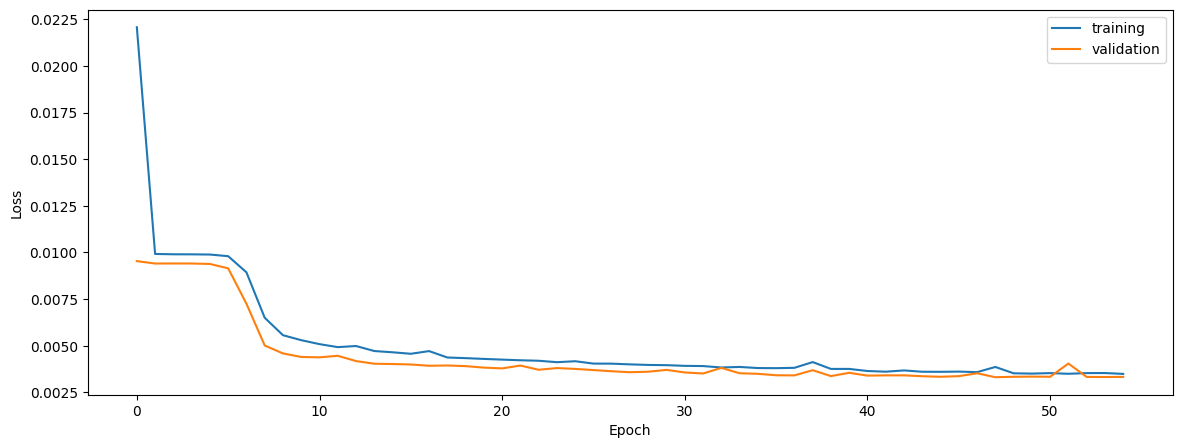

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7981594348178663
0.8056277838676387
0.7485976939809916


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7981594348178663
0.8056277838676387
0.7485976939809916


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8018332796094321
0.8053840156750034
0.7628667556223613


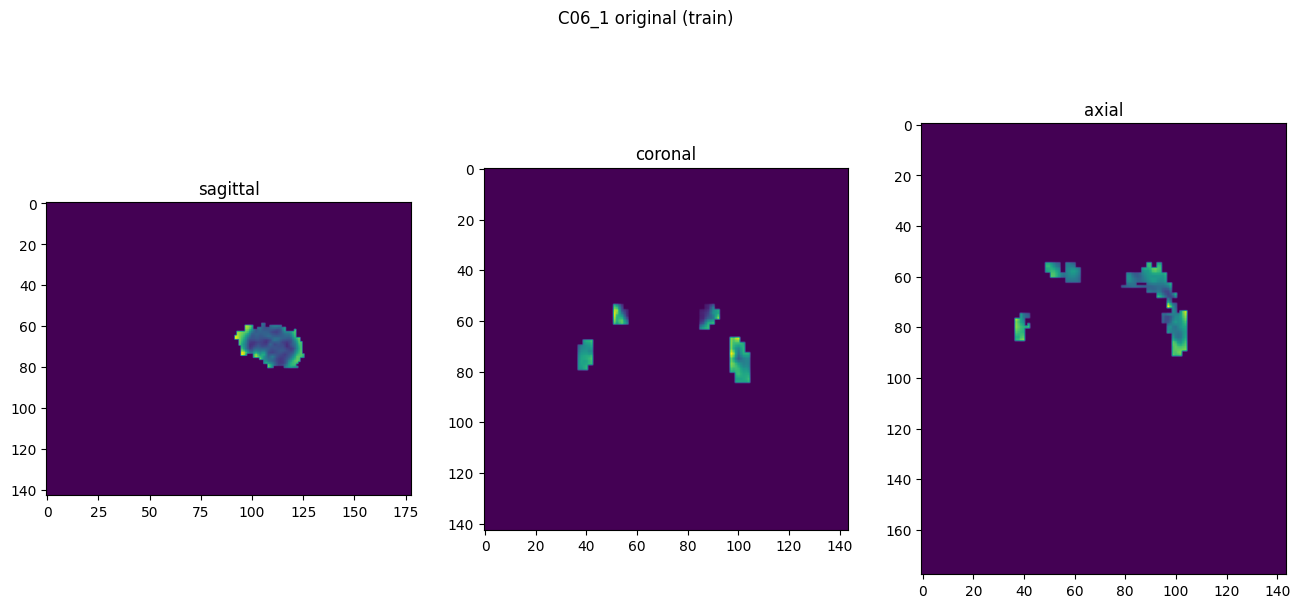

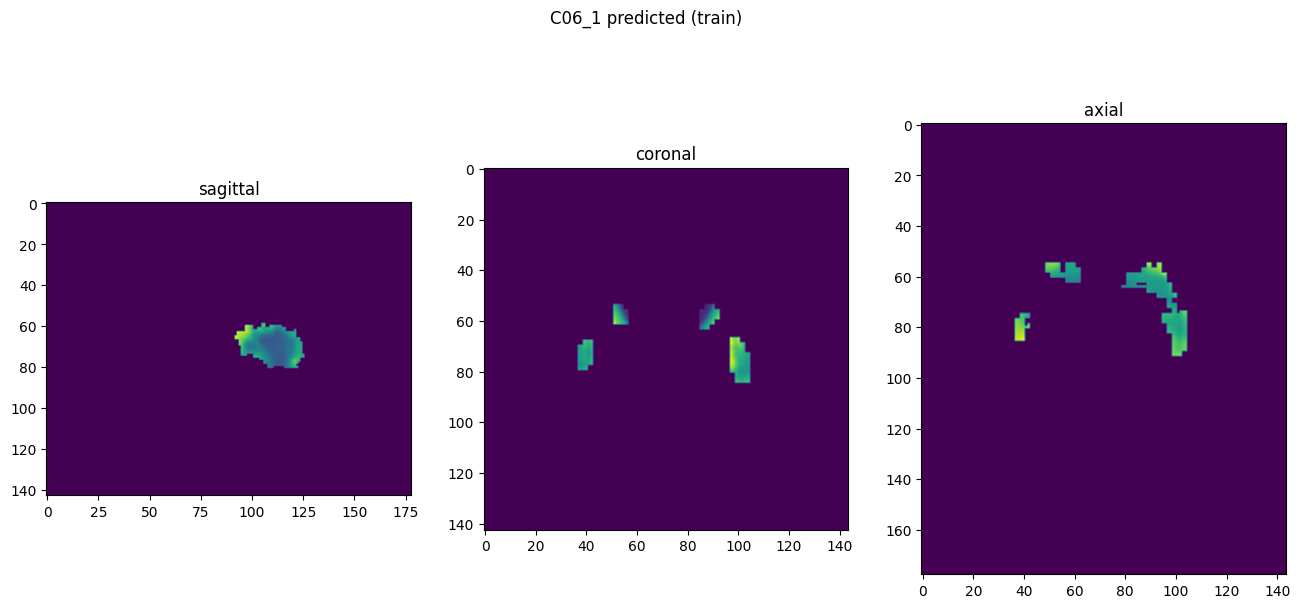

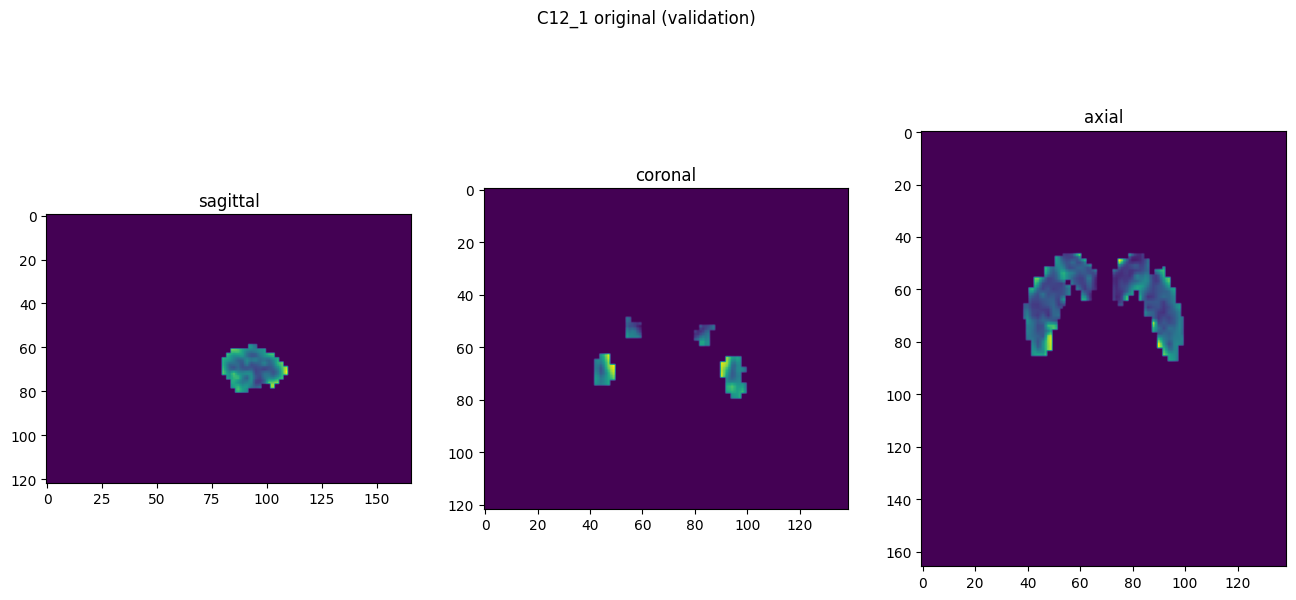

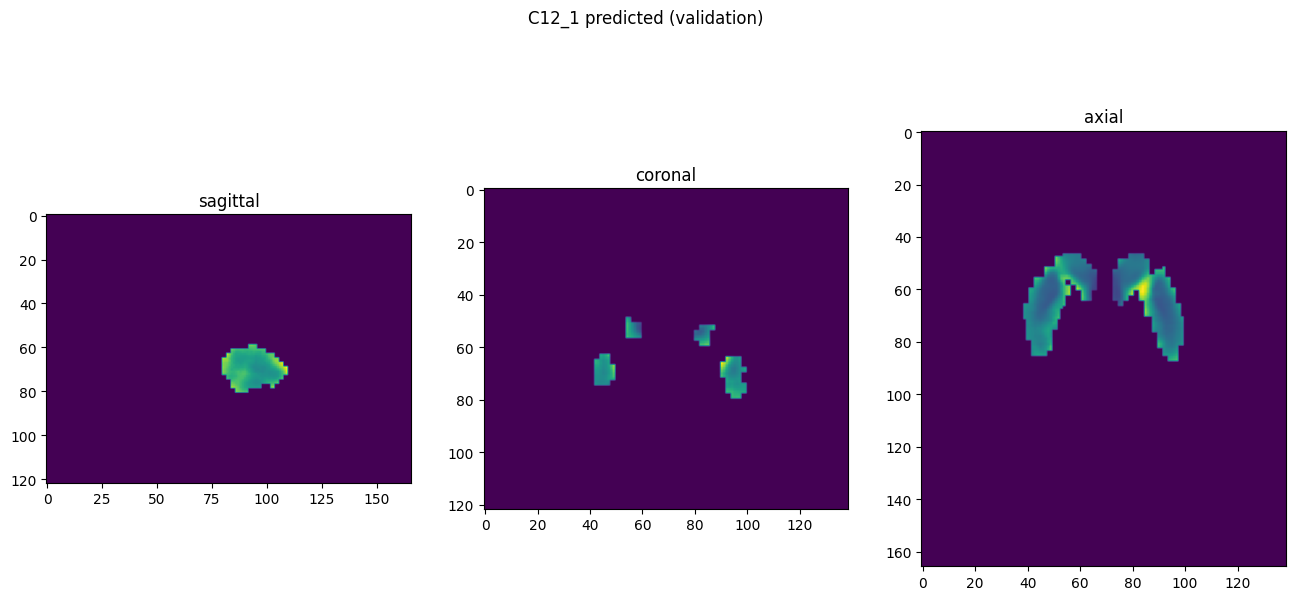

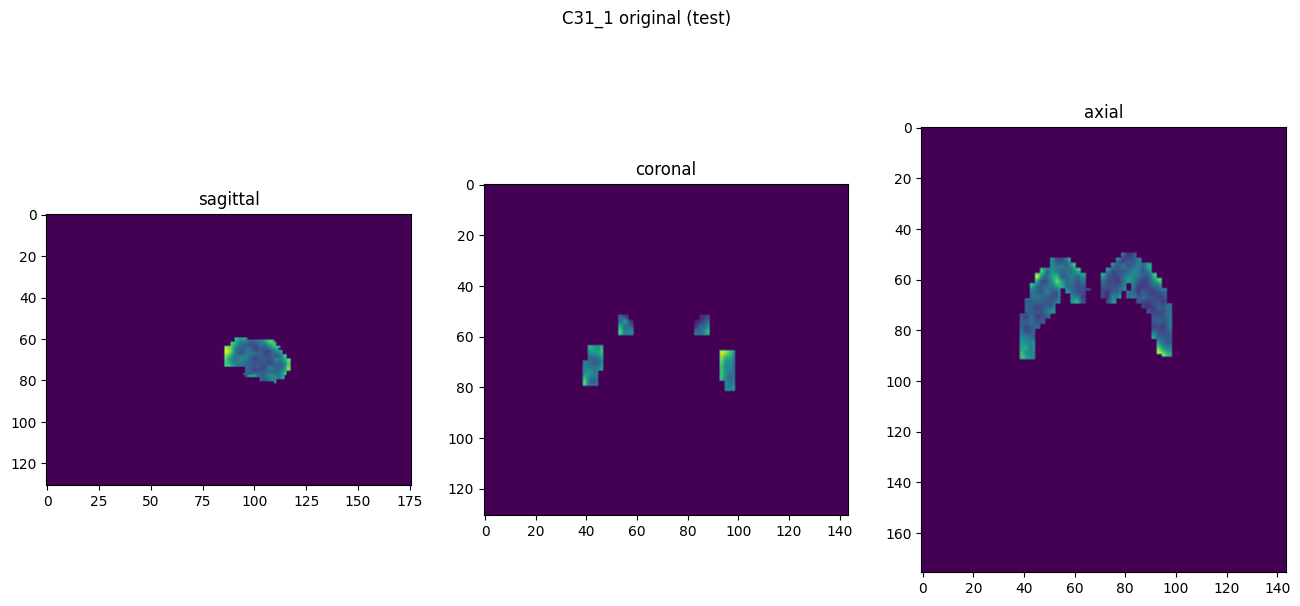

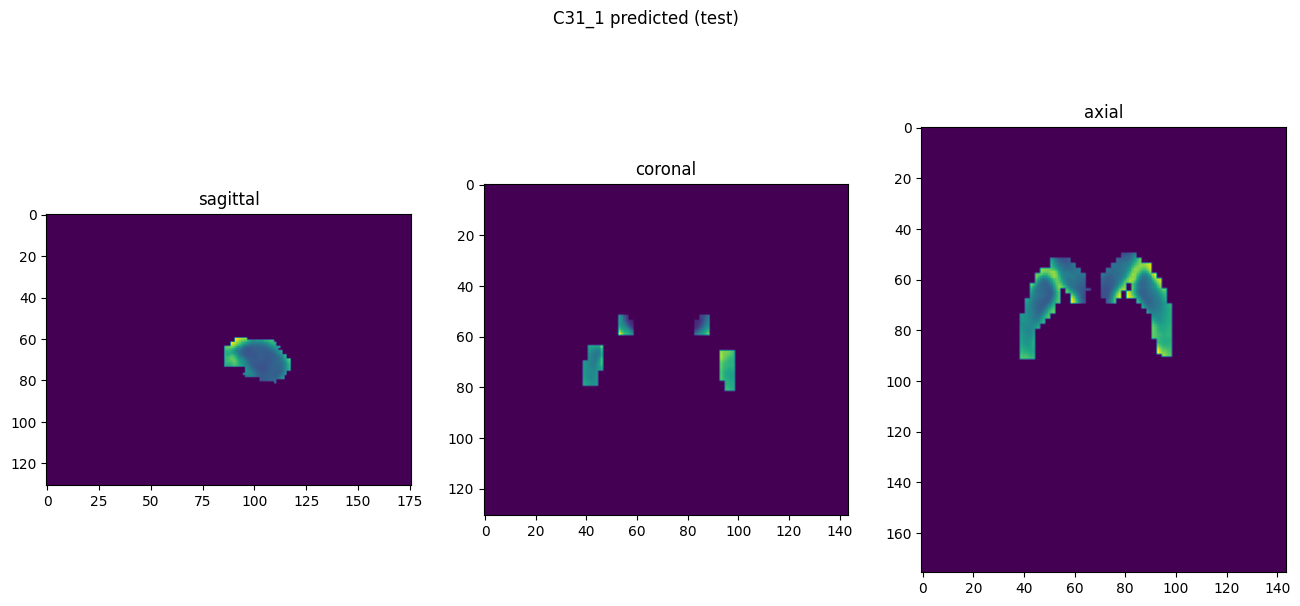

In [10]:
showResults(model, gen, threshold=None, background=False)